# Predicting long-term player engagement in Steam games: A machine learning approach

### Loading libraries

In [1]:
## Import libraries

# General packages
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Data preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Model training
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Model evaluation
from sklearn.metrics import r2_score,mean_squared_error
from yellowbrick.regressor import PredictionError, ResidualsPlot


In [2]:
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 100)


In [3]:
# pd.reset_option('display.max_rows')
# pd.reset_option('display.max_columns')


#### Load datasets

In [4]:
# Import datasets
games = pd.read_csv('data/games.csv')

player_count = pd.read_csv('data/steam_player_count.csv')

In [5]:
# Remove whitespace and replace with underscores in feature names
games.rename(columns=lambda x: x.strip().replace(' ', '_'), inplace=True)

In [6]:
games.head()

,AppID,Name,Release_date,Estimated_owners,Peak_CCU,Required_age,Price,DLC_count,About_the_game,Supported_languages,Full_audio_languages,Reviews,Header_image,Website,Support_url,Support_email,Windows,Mac,Linux,Metacritic_score,Metacritic_url,User_score,Positive,Negative,Score_rank,Achievements,Recommendations,Notes,Average_playtime_forever,Average_playtime_two_weeks,Median_playtime_forever,Median_playtime_two_weeks,Developers,Publishers,Categories,Genres,Tags,Screenshots,Movies
0,20200,Galactic Bowling,"Oct 21, 2008",0 - 20000,0,0,19.99,0,Galactic Bowling is an exaggerated and stylize...,['English'],[],NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://www.galacticbowling.net,NaN,NaN,True,False,False,0,NaN,0,6,11,NaN,30,0,NaN,0,0,0,0,Perpetual FX Creative,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports","Indie,Casual,Sports,Bowling",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
1,655370,Train Bandit,"Oct 12, 2017",0 - 20000,0,0,0.99,0,THE LAW!! Looks to be a showdown atop a train....,"['English', 'French', 'Italian', 'German', 'Sp...",[],NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://trainbandit.com,NaN,support@rustymoyher.com,True,True,False,0,NaN,0,53,5,NaN,12,0,NaN,0,0,0,0,Rusty Moyher,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
2,1732930,Jolt Project,"Nov 17, 2021",0 - 20000,0,0,4.99,0,Jolt Project: The army now has a new robotics ...,"['English', 'Portuguese - Brazil']",[],NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,NaN,NaN,ramoncampiaof31@gmail.com,True,False,False,0,NaN,0,0,0,NaN,0,0,NaN,0,0,0,0,Campião Games,Campião Games,Single-player,"Action,Adventure,Indie,Strategy",NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
3,1355720,Henosis™,"Jul 23, 2020",0 - 20000,0,0,5.99,0,HENOSIS™ is a mysterious 2D Platform Puzzler w...,"['English', 'French', 'Italian', 'German', 'Sp...",[],NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,https://henosisgame.com/,https://henosisgame.com/,info@henosisgame.com,True,True,True,0,NaN,0,3,0,NaN,0,0,NaN,0,0,0,0,Odd Critter Games,Odd Critter Games,"Single-player,Full controller support","Adventure,Casual,Indie","2D Platformer,Atmospheric,Surreal,Mystery,Puzz...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
4,1139950,Two Weeks in Painland,"Feb 3, 2020",0 - 20000,0,0,0.00,0,ABOUT THE GAME Play as a hacker who has arrang...,"['English', 'Spanish - Spain']",[],NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,https://www.unusual-games.com/home/,https://www.unusual-games.com/contact/,welistentoyou@unusual-games.com,True,True,False,0,NaN,0,50,8,NaN,17,0,This Game may contain content not appropriate ...,0,0,0,0,Unusual Games,Unusual Games,"Single-player,Steam Achievements","Adventure,Indie","Indie,Adventure,Nudity,Violent,Sexual Content,...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...


In [7]:
player_count.head()

,AppID,Name,Month,Avg_players,Gain,Gain_percentage,Peak_players
0,289070,Sid Meier's Civilization VI,last 30 days,42728,-2.50,-0.01,79091
1,289070,Sid Meier's Civilization VI,2023-10-31,42731,2034.40,5.00,79091
2,289070,Sid Meier's Civilization VI,2023-09-30,40696,1494.98,3.81,71302
3,289070,Sid Meier's Civilization VI,2023-08-31,39201,-6038.87,-13.35,64578
4,289070,Sid Meier's Civilization VI,2023-07-30,45240,8752.32,23.99,71580


In [8]:
# Print column names
print(games.columns)
print(player_count.columns)

Index(['AppID', 'Name', 'Release_date', 'Estimated_owners', 'Peak_CCU',
       'Required_age', 'Price', 'DLC_count', 'About_the_game',
       'Supported_languages', 'Full_audio_languages', 'Reviews',
       'Header_image', 'Website', 'Support_url', 'Support_email', 'Windows',
       'Mac', 'Linux', 'Metacritic_score', 'Metacritic_url', 'User_score',
       'Positive', 'Negative', 'Score_rank', 'Achievements', 'Recommendations',
       'Notes', 'Average_playtime_forever', 'Average_playtime_two_weeks',
       'Median_playtime_forever', 'Median_playtime_two_weeks', 'Developers',
       'Publishers', 'Categories', 'Genres', 'Tags', 'Screenshots', 'Movies'],
      dtype='object')
Index(['AppID', 'Name', 'Month', 'Avg_players', 'Gain', 'Gain_percentage',
       'Peak_players'],
      dtype='object')


In [9]:
print(player_count.info())
print('number of unique appids in player count df:',player_count['AppID'].nunique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589393 entries, 0 to 589392
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   AppID            589393 non-null  int64  
 1   Name             589393 non-null  object 
 2   Month            589393 non-null  object 
 3   Avg_players      589393 non-null  int64  
 4   Gain             589393 non-null  float64
 5   Gain_percentage  588287 non-null  float64
 6   Peak_players     589393 non-null  int64  
dtypes: float64(2), int64(3), object(2)
memory usage: 31.5+ MB
None
number of unique appids in player count df: 11652


In [10]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76987 entries, 0 to 76986
Data columns (total 39 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   AppID                       76987 non-null  int64  
 1   Name                        76985 non-null  object 
 2   Release_date                76987 non-null  object 
 3   Estimated_owners            76987 non-null  object 
 4   Peak_CCU                    76987 non-null  int64  
 5   Required_age                76987 non-null  int64  
 6   Price                       76987 non-null  float64
 7   DLC_count                   76987 non-null  int64  
 8   About_the_game              74070 non-null  object 
 9   Supported_languages         76987 non-null  object 
 10  Full_audio_languages        76987 non-null  object 
 11  Reviews                     9362 non-null   object 
 12  Header_image                76987 non-null  object 
 13  Website                     366

## Predicting metascore

### Data cleaning

In [11]:
# Remove uneccessary columns from games dataset
games_cols_to_drop = [
    'Peak_CCU',
    'About_the_game',
    'Reviews',
    'Header_image', 
    'Website', 
    'Support_url', 
    'Support_email', 
    'Metacritic_url', 
    'User_score', 
    'Score_rank',
    'Notes',
    'Average_playtime_two_weeks',
    'Median_playtime_forever', 
    'Median_playtime_two_weeks',
    'Screenshots', 
    'Movies',
    'Tags',
    'Average_playtime_forever',
    'Full_audio_languages',
    'Estimated_owners',
    'Positive', 
    'Negative', 
    'Recommendations',
] 

games = games.drop(columns=games_cols_to_drop)


In [12]:
# Drop rows that do not contain Metacritic score
games = games[games['Metacritic_score'] != 0]
games

,AppID,Name,Release_date,Required_age,Price,DLC_count,Supported_languages,Windows,Mac,Linux,Metacritic_score,Achievements,Developers,Publishers,Categories,Genres
10,1026420,WARSAW,"Oct 2, 2019",0,23.99,0,"['English', 'French', 'German', 'Polish', 'Rus...",True,False,False,62,34,Pixelated Milk,"Pixelated Milk,gaming company","Single-player,Steam Achievements,Steam Trading...","Indie,RPG"
15,22670,Alien Breed 3: Descent,"Nov 17, 2010",0,9.99,0,"['English', 'French', 'German', 'Italian', 'Ja...",True,False,False,64,13,Team17 Digital Ltd,Team17 Digital Ltd,"Single-player,Multi-player,Co-op,Steam Achieve...",Action
42,231330,Deadfall Adventures,"Nov 15, 2013",0,19.99,0,"['English', 'German', 'Polish', 'French', 'Rus...",True,False,True,53,50,The Farm 51,THQ Nordic,"Single-player,Multi-player,Co-op,Steam Achieve...","Action,Adventure"
44,897820,Reigns: Game of Thrones,"Oct 18, 2018",0,3.99,0,"['English', 'French', 'German', 'Spanish - Spa...",True,True,True,84,10,Nerial,Devolver Digital,"Single-player,Steam Achievements,Full controll...","Adventure,Indie,RPG"
66,12140,Max Payne,"Jan 6, 2011",17,3.49,0,['English'],True,False,False,89,0,Remedy Entertainment,Rockstar Games,Single-player,Action
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75106,2228030,Dr. Fetus' Mean Meat Machine,"Jun 22, 2023",0,8.99,0,"['English', 'French', 'Italian', 'German', 'Sp...",True,False,False,83,30,Headup Development,Headup Publishing,"Single-player,Steam Achievements,Full controll...","Action,Casual,Indie"
75197,1164940,Trepang2,"Jun 21, 2023",0,29.99,1,"['English', 'French', 'Italian', 'German', 'Sp...",True,False,False,77,49,Trepang Studios,Team17,"Single-player,Steam Achievements,Full controll...","Action,Indie"
76012,1736290,Crime O'Clock,"Jul 21, 2023",0,16.99,0,"['English', 'French', 'Italian', 'German', 'Sp...",True,True,False,76,20,Bad Seed,Just For Games,"Single-player,Steam Achievements,Steam Cloud","Adventure,Casual,Indie"
76071,1382070,Viewfinder,"Jul 18, 2023",0,24.99,0,"['English', 'French', 'Italian', 'German', 'Sp...",True,False,False,83,46,Sad Owl Studios,Thunderful Publishing,"Single-player,Steam Achievements,Full controll...","Adventure,Indie"


In [13]:
games.dtypes

AppID                    int64
Name                    object
Release_date            object
Required_age             int64
Price                  float64
DLC_count                int64
Supported_languages     object
Windows                   bool
Mac                       bool
Linux                     bool
Metacritic_score         int64
Achievements             int64
Developers              object
Publishers              object
Categories              object
Genres                  object
dtype: object

In [14]:
# Remove nan and inf rows
player_count.replace([np.inf, -np.inf], 0, inplace=True) 

# Remove 'last 30 days' rows from player count dataframe as they overlap with the month before
player_count = player_count[player_count['Month'] != 'last 30 days']
player_count

,AppID,Name,Month,Avg_players,Gain,Gain_percentage,Peak_players
1,289070,Sid Meier's Civilization VI,2023-10-31,42731,2034.40,5.00,79091
2,289070,Sid Meier's Civilization VI,2023-09-30,40696,1494.98,3.81,71302
3,289070,Sid Meier's Civilization VI,2023-08-31,39201,-6038.87,-13.35,64578
4,289070,Sid Meier's Civilization VI,2023-07-30,45240,8752.32,23.99,71580
5,289070,Sid Meier's Civilization VI,2023-06-30,36488,-1923.53,-5.01,61278
...,...,...,...,...,...,...,...
589387,730,Counter-Strike 2,2012-10-31,10739,-5261.27,-32.88,20850
589388,730,Counter-Strike 2,2012-09-30,16001,525.36,3.39,36057
589389,730,Counter-Strike 2,2012-08-31,15475,14542.81,1559.43,52261
589390,730,Counter-Strike 2,2012-07-30,933,0.00,0.00,1642


In [15]:
### Cleaning columns
print(games.isnull().sum())
print(games.shape)

AppID                   0
Name                    0
Release_date            0
Required_age            0
Price                   0
DLC_count               0
Supported_languages     0
Windows                 0
Mac                     0
Linux                   0
Metacritic_score        0
Achievements            0
Developers             11
Publishers             29
Categories              3
Genres                  5
dtype: int64
(3792, 16)


In [16]:
# Create copy of games df
games_cleaned = games.copy()

In [17]:
# Remove empty rows
games_cleaned = games_cleaned.dropna(axis='rows')
games_cleaned = games_cleaned.dropna(axis='rows')

In [18]:
print(games_cleaned.isnull().sum())
print(games_cleaned.shape)

AppID                  0
Name                   0
Release_date           0
Required_age           0
Price                  0
DLC_count              0
Supported_languages    0
Windows                0
Mac                    0
Linux                  0
Metacritic_score       0
Achievements           0
Developers             0
Publishers             0
Categories             0
Genres                 0
dtype: int64
(3746, 16)


In [19]:
# remove empty language rows
games_cleaned = games_cleaned.loc[games['Supported_languages'] != '[]']
games_cleaned.shape

(3746, 16)

In [20]:
# Remove brackets from the string
games_cleaned['Supported_languages'] = games_cleaned['Supported_languages'].str.strip("[]").str.replace("'", "")

# Remove the text about the dialect from a language
games_cleaned['Supported_languages'] = games_cleaned['Supported_languages'].str.split('-').str[0]

# Rename the variats of Chinese the same
games_cleaned['Supported_languages'] = games_cleaned['Supported_languages'].str.replace('Traditional Chinese', 'Chinese').str.replace('Simplified Chinese', 'Chinese')

# Split into list
games_cleaned['Supported_languages'] = games_cleaned['Supported_languages'].str.strip().str.split(pat= ",")

In [21]:
from collections import Counter

# Flatten the list of languages into a single list
all_languages = [language.strip() for sublist in games_cleaned['Supported_languages'] for language in sublist]

# Count the occurrences of each language
language_counts = Counter(all_languages)

# Convert the language counts to a pandas DataFrame
language_counts_df = pd.DataFrame.from_dict(language_counts, orient='index', columns=['Count'])

In [22]:
# Export the language count 
language_counts_df = language_counts_df.sort_values(by='Count', ascending=False)
language_counts_df.to_csv('language_counts.csv')

In [23]:
language_counts_df.sum()

Count    14407
dtype: int64

In [24]:
# Remove whitespace and replace with underscores in feature names
games_cleaned.rename(columns=lambda x: x.strip().replace(' ', '_'), inplace=True)

In [25]:
games_cleaned

,AppID,Name,Release_date,Required_age,Price,DLC_count,Supported_languages,Windows,Mac,Linux,Metacritic_score,Achievements,Developers,Publishers,Categories,Genres
10,1026420,WARSAW,"Oct 2, 2019",0,23.99,0,"[English, French, German, Polish, Russian]",True,False,False,62,34,Pixelated Milk,"Pixelated Milk,gaming company","Single-player,Steam Achievements,Steam Trading...","Indie,RPG"
15,22670,Alien Breed 3: Descent,"Nov 17, 2010",0,9.99,0,"[English, French, German, Italian, Japanes...",True,False,False,64,13,Team17 Digital Ltd,Team17 Digital Ltd,"Single-player,Multi-player,Co-op,Steam Achieve...",Action
42,231330,Deadfall Adventures,"Nov 15, 2013",0,19.99,0,"[English, German, Polish, French, Russian]",True,False,True,53,50,The Farm 51,THQ Nordic,"Single-player,Multi-player,Co-op,Steam Achieve...","Action,Adventure"
44,897820,Reigns: Game of Thrones,"Oct 18, 2018",0,3.99,0,"[English, French, German, Spanish]",True,True,True,84,10,Nerial,Devolver Digital,"Single-player,Steam Achievements,Full controll...","Adventure,Indie,RPG"
66,12140,Max Payne,"Jan 6, 2011",17,3.49,0,[English],True,False,False,89,0,Remedy Entertainment,Rockstar Games,Single-player,Action
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75106,2228030,Dr. Fetus' Mean Meat Machine,"Jun 22, 2023",0,8.99,0,"[English, French, Italian, German, Spanish]",True,False,False,83,30,Headup Development,Headup Publishing,"Single-player,Steam Achievements,Full controll...","Action,Casual,Indie"
75197,1164940,Trepang2,"Jun 21, 2023",0,29.99,1,"[English, French, Italian, German, Spanish]",True,False,False,77,49,Trepang Studios,Team17,"Single-player,Steam Achievements,Full controll...","Action,Indie"
76012,1736290,Crime O'Clock,"Jul 21, 2023",0,16.99,0,"[English, French, Italian, German, Spanish]",True,True,False,76,20,Bad Seed,Just For Games,"Single-player,Steam Achievements,Steam Cloud","Adventure,Casual,Indie"
76071,1382070,Viewfinder,"Jul 18, 2023",0,24.99,0,"[English, French, Italian, German, Spanish]",True,False,False,83,46,Sad Owl Studios,Thunderful Publishing,"Single-player,Steam Achievements,Full controll...","Adventure,Indie"


In [26]:
print(games_cleaned.Developers.nunique())
print(games_cleaned.Publishers.nunique())

2397
1502


### Feature engineering

In [27]:
games_feat = games_cleaned.copy()

In [28]:
# Dummy code genres 
dummy_genres = games_feat['Genres'].str.get_dummies(',')
dummy_genres.columns

Index(['Action', 'Adventure', 'Casual', 'Early Access', 'Free to Play', 'Gore',
       'Indie', 'Massively Multiplayer', 'Nudity', 'RPG', 'Racing',
       'Sexual Content', 'Simulation', 'Sports', 'Strategy', 'Violent'],
      dtype='object')

In [29]:
# Concatenate the dummy-coded columns to games df
games_feat = pd.concat([games_feat, dummy_genres], axis=1)


In [30]:
print(games_feat.columns)

Index(['AppID', 'Name', 'Release_date', 'Required_age', 'Price', 'DLC_count',
       'Supported_languages', 'Windows', 'Mac', 'Linux', 'Metacritic_score',
       'Achievements', 'Developers', 'Publishers', 'Categories', 'Genres',
       'Action', 'Adventure', 'Casual', 'Early Access', 'Free to Play', 'Gore',
       'Indie', 'Massively Multiplayer', 'Nudity', 'RPG', 'Racing',
       'Sexual Content', 'Simulation', 'Sports', 'Strategy', 'Violent'],
      dtype='object')


In [31]:
## Not necessary to remove, as these games were already removed when dropping games with no metascore
# columns_to_check = ['360 Video', 
#                     'Accounting', 
#                     'Animation & Modeling', 
#                     'Audio Production' , 
#                     'Design & Illustration', 
#                     'Documentary', 
#                     'Game Development', 
#                     'Photo Editing', 
#                     'Software Training', 
#                     'Utilities', 
#                     'Video Production', 
#                     'Web Publishing']

# # Create a boolean mask to identify rows where any of the specified columns have a value of 1
# mask = games_feat[columns_to_check].eq(1).any(axis=1)          

# # Drop the rows where the mask is True
# games_feat = games_feat.drop(games_feat[mask].index)

In [33]:
# # Remove the unrelated columns
# games_feat = games_feat.drop(columns= ['360 Video', 
#                     'Accounting', 
#                     'Animation & Modeling', 
#                     'Audio Production' , 
#                     'Design & Illustration', 
#                     'Documentary', 
#                     'Game Development', 
#                     'Photo Editing', 
#                     'Software Training', 
#                     'Utilities', 
#                     'Video Production', 
#                     'Web Publishing'])

In [34]:
# Dummy code categories
dummy_categ = games_feat['Categories'].str.get_dummies(',')
dummy_categ.columns

Index(['Captions available', 'Co-op', 'Commentary available',
       'Cross-Platform Multiplayer', 'Full controller support',
       'In-App Purchases', 'Includes Source SDK', 'Includes level editor',
       'LAN Co-op', 'LAN PvP', 'MMO', 'Multi-player', 'Online Co-op',
       'Online PvP', 'Partial Controller Support', 'PvP',
       'Remote Play Together', 'Remote Play on Phone', 'Remote Play on TV',
       'Remote Play on Tablet', 'Shared/Split Screen',
       'Shared/Split Screen Co-op', 'Shared/Split Screen PvP', 'Single-player',
       'Stats', 'Steam Achievements', 'Steam Cloud', 'Steam Leaderboards',
       'Steam Trading Cards', 'Steam Turn Notifications', 'Steam Workshop',
       'SteamVR Collectibles', 'VR Support', 'Valve Anti-Cheat enabled'],
      dtype='object')

In [35]:
# Concatinate categories to games df
games_feat = pd.concat([games_feat, dummy_categ], axis=1)
games_feat.columns

Index(['AppID', 'Name', 'Release_date', 'Required_age', 'Price', 'DLC_count',
       'Supported_languages', 'Windows', 'Mac', 'Linux', 'Metacritic_score',
       'Achievements', 'Developers', 'Publishers', 'Categories', 'Genres',
       'Action', 'Adventure', 'Casual', 'Early Access', 'Free to Play', 'Gore',
       'Indie', 'Massively Multiplayer', 'Nudity', 'RPG', 'Racing',
       'Sexual Content', 'Simulation', 'Sports', 'Strategy', 'Violent',
       'Captions available', 'Co-op', 'Commentary available',
       'Cross-Platform Multiplayer', 'Full controller support',
       'In-App Purchases', 'Includes Source SDK', 'Includes level editor',
       'LAN Co-op', 'LAN PvP', 'MMO', 'Multi-player', 'Online Co-op',
       'Online PvP', 'Partial Controller Support', 'PvP',
       'Remote Play Together', 'Remote Play on Phone', 'Remote Play on TV',
       'Remote Play on Tablet', 'Shared/Split Screen',
       'Shared/Split Screen Co-op', 'Shared/Split Screen PvP', 'Single-player',
       'St

In [36]:
# Create total supported languages feature
games_feat['Lang_count'] = games_feat['Supported_languages'].apply(lambda x: len(x))
games_feat

,AppID,Name,Release_date,Required_age,Price,DLC_count,Supported_languages,Windows,Mac,Linux,Metacritic_score,Achievements,Developers,Publishers,Categories,Genres,Action,Adventure,Casual,Early Access,Free to Play,Gore,Indie,Massively Multiplayer,Nudity,RPG,Racing,Sexual Content,Simulation,Sports,Strategy,Violent,Captions available,Co-op,Commentary available,Cross-Platform Multiplayer,Full controller support,In-App Purchases,Includes Source SDK,Includes level editor,LAN Co-op,LAN PvP,MMO,Multi-player,Online Co-op,Online PvP,Partial Controller Support,PvP,Remote Play Together,Remote Play on Phone,Remote Play on TV,Remote Play on Tablet,Shared/Split Screen,Shared/Split Screen Co-op,Shared/Split Screen PvP,Single-player,Stats,Steam Achievements,Steam Cloud,Steam Leaderboards,Steam Trading Cards,Steam Turn Notifications,Steam Workshop,SteamVR Collectibles,VR Support,Valve Anti-Cheat enabled,Lang_count
10,1026420,WARSAW,"Oct 2, 2019",0,23.99,0,"[English, French, German, Polish, Russian]",True,False,False,62,34,Pixelated Milk,"Pixelated Milk,gaming company","Single-player,Steam Achievements,Steam Trading...","Indie,RPG",0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0,1,0,0,0,0,0,5
15,22670,Alien Breed 3: Descent,"Nov 17, 2010",0,9.99,0,"[English, French, German, Italian, Japanes...",True,False,False,64,13,Team17 Digital Ltd,Team17 Digital Ltd,"Single-player,Multi-player,Co-op,Steam Achieve...",Action,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,0,0,0,6
42,231330,Deadfall Adventures,"Nov 15, 2013",0,19.99,0,"[English, German, Polish, French, Russian]",True,False,True,53,50,The Farm 51,THQ Nordic,"Single-player,Multi-player,Co-op,Steam Achieve...","Action,Adventure",1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,1,1,1,0,0,0,0,0,5
44,897820,Reigns: Game of Thrones,"Oct 18, 2018",0,3.99,0,"[English, French, German, Spanish]",True,True,True,84,10,Nerial,Devolver Digital,"Single-player,Steam Achievements,Full controll...","Adventure,Indie,RPG",0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,4
66,12140,Max Payne,"Jan 6, 2011",17,3.49,0,[English],True,False,False,89,0,Remedy Entertainment,Rockstar Games,Single-player,Action,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75106,2228030,Dr. Fetus' Mean Meat Machine,"Jun 22, 2023",0,8.99,0,"[English, French, Italian, German, Spanish]",True,False,False,83,30,Headup Development,Headup Publishing,"Single-player,Steam Achievements,Full controll...","Action,Casual,Indie",1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,5
75197,1164940,Trepang2,"Jun 21, 2023",0,29.99,1,"[English, French, Italian, German, Spanish]",True,False,False,77,49,Trepang Studios,Team17,"Single-player,Steam Achievements,Full controll...","Action,Indie",1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,5
76012,1736290,Crime O'Clock,"Jul 21, 2023",0,16.99,0,"[English, French, Italian, German, Spanish]",True,True,False,76,20,Bad Seed,Just For Games,"Single-player,Steam Achievements,Steam Cloud","Adventure,Casual,Indie",0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,5
76071,1382070,Viewfinder,"Jul 18, 2023",0,24.99,0,"[English, French, Italian, German, Spanish]",True,False,False,83,46,Sad Owl Studios,Thunderful Publishing,"Single-player,Steam Achievements,Full controll...","Adventure,Indie",0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,

In [37]:
# Create supported language features
games_feat['Lang_eng'] = games_feat['Supported_languages'].apply(lambda x: 'English' in x)
# games_feat['Lang_ger'] = games_feat['Supported_languages'].apply(lambda x: 'German' in x)
# games_feat['Lang_fr'] = games_feat['Supported_languages'].apply(lambda x: 'French' in x)
# games_feat['Lang_spa'] = games_feat['Supported_languages'].apply(lambda x: 'Spanish' in x)
# games_feat['Lang_ita'] = games_feat['Supported_languages'].apply(lambda x: 'Italian' in x)

In [38]:
# Create developer game count feature and publisher game count feature
games_feat['Dev_released'] = games_feat.groupby('Developers')['Developers'].transform('count')
games_feat['Publisher_released'] = games_feat.groupby('Publishers')['Publishers'].transform('count')

In [39]:
# Drop the columns that are dummy coded 
games_feat = games_feat.drop(columns=['Supported_languages', 'Categories', 'Genres'])

# Drop Publishers and Developers columns
games_feat = games_feat.drop(columns=['Developers', 'Publishers'])


In [40]:
# Remove whitespace and replace with underscores in feature names
games_feat.rename(columns=lambda x: x.strip().replace(' ', '_'), inplace=True)

In [41]:
games_feat.isna().sum()

AppID                       0
Name                        0
Release_date                0
Required_age                0
Price                       0
                           ..
Valve_Anti-Cheat_enabled    0
Lang_count                  0
Lang_eng                    0
Dev_released                0
Publisher_released          0
Length: 65, dtype: int64

In [42]:
# Merge Genres that are similar to avoid overlap

games_feat['Genre_PvP'] = games_feat['PvP'] | games_feat['Online_PvP'] | games_feat['LAN_PvP']
games_feat['Genre_Coop'] = games_feat['Online_Co-op'] | games_feat['Co-op'] | games_feat['LAN_Co-op']
games_feat['Controller_support'] = games_feat['Full_controller_support'] | games_feat['Partial_Controller_Support']
games_feat['Shared_screen'] = games_feat['Shared/Split_Screen_Co-op'] | games_feat['Shared/Split_Screen_PvP'] | games_feat['Shared/Split_Screen']
games_feat['Steam_support'] = games_feat['Steam_Achievements'] | games_feat['Steam_Cloud'] | games_feat['Steam_Leaderboards'] | games_feat['Steam_Trading_Cards'] | games_feat['Steam_Workshop'] | games_feat["Steam_Turn_Notifications"] | games_feat['SteamVR_Collectibles']
games_feat['Genre_multiplayer'] = games_feat['Massively_Multiplayer'] | games_feat['Multi-player'] | games_feat['Cross-Platform_Multiplayer']

In [43]:
# Drop redundant columns
games_feat = games_feat.drop(columns=['PvP', 'Online_PvP', 'Full_controller_support', 'Partial_Controller_Support', 'Shared/Split_Screen', 'Shared/Split_Screen_PvP', 'Shared/Split_Screen_Co-op','LAN_Co-op', 'LAN_PvP', 'Online_Co-op', 'Co-op', 'Remote_Play_Together', 'Remote_Play_on_Phone', 'Remote_Play_on_TV', 'Remote_Play_on_Tablet'])
games_feat = games_feat.drop(columns=['Steam_Achievements', 'Steam_Cloud', 'Steam_Leaderboards', 'Steam_Trading_Cards', 'Steam_Workshop', "Steam_Turn_Notifications", 'SteamVR_Collectibles'])
games_feat = games_feat.drop(columns=['Massively_Multiplayer', 'Multi-player', 'Cross-Platform_Multiplayer'])

games_feat

,AppID,Name,Release_date,Required_age,Price,DLC_count,Windows,Mac,Linux,Metacritic_score,Achievements,Action,Adventure,Casual,Early_Access,Free_to_Play,Gore,Indie,Nudity,RPG,Racing,Sexual_Content,Simulation,Sports,Strategy,Violent,Captions_available,Commentary_available,In-App_Purchases,Includes_Source_SDK,Includes_level_editor,MMO,Single-player,Stats,VR_Support,Valve_Anti-Cheat_enabled,Lang_count,Lang_eng,Dev_released,Publisher_released,Genre_PvP,Genre_Coop,Controller_support,Shared_screen,Steam_support,Genre_multiplayer
10,1026420,WARSAW,"Oct 2, 2019",0,23.99,0,True,False,False,62,34,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,5,True,2,1,0,0,0,0,1,0
15,22670,Alien Breed 3: Descent,"Nov 17, 2010",0,9.99,0,True,False,False,64,13,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,6,True,9,24,0,1,1,0,1,1
42,231330,Deadfall Adventures,"Nov 15, 2013",0,19.99,0,True,False,True,53,50,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,5,True,5,73,0,1,1,0,1,1
44,897820,Reigns: Game of Thrones,"Oct 18, 2018",0,3.99,0,True,True,True,84,10,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,4,True,2,67,0,0,1,0,1,0
66,12140,Max Payne,"Jan 6, 2011",17,3.49,0,True,False,False,89,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,True,6,10,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75106,2228030,Dr. Fetus' Mean Meat Machine,"Jun 22, 2023",0,8.99,0,True,False,False,83,30,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,5,True,1,1,0,0,1,0,1,0
75197,1164940,Trepang2,"Jun 21, 2023",0,29.99,1,True,False,False,77,49,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,5,True,1,15,0,0,1,0,1,0
76012,1736290,Crime O'Clock,"Jul 21, 2023",0,16.99,0,True,True,False,76,20,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,5,True,1,1,0,0,0,0,1,0
76071,1382070,Viewfinder,"Jul 18, 2023",0,24.99,0,True,False,False,83,46,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,5,True,1,5,0,0,1,0,1,0


#### Final merge of player count and steam store datasets

In [44]:
# Merge Steam API dataset with Steacharts dataset on AppID
merged_data = pd.merge(games_feat, player_count, on="AppID")

In [45]:
# Drop NaN rows
merged_data = merged_data.dropna(axis='rows')

In [47]:
print(merged_data.isnull().sum())
print(merged_data['AppID'].nunique())
print(merged_data.dtypes)
print(merged_data.columns)

AppID              0
Name_x             0
Release_date       0
Required_age       0
Price              0
                  ..
Month              0
Avg_players        0
Gain               0
Gain_percentage    0
Peak_players       0
Length: 52, dtype: int64
2013
AppID                int64
Name_x              object
Release_date        object
Required_age         int64
Price              float64
                    ...   
Month               object
Avg_players          int64
Gain               float64
Gain_percentage    float64
Peak_players         int64
Length: 52, dtype: object
Index(['AppID', 'Name_x', 'Release_date', 'Required_age', 'Price', 'DLC_count',
       'Windows', 'Mac', 'Linux', 'Metacritic_score', 'Achievements', 'Action',
       'Adventure', 'Casual', 'Early_Access', 'Free_to_Play', 'Gore', 'Indie',
       'Nudity', 'RPG', 'Racing', 'Sexual_Content', 'Simulation', 'Sports',
       'Strategy', 'Violent', 'Captions_available', 'Commentary_available',
       'In-App_Purchases'

### EDA

In [48]:
# Create descriptive statistics table
columns_to_describe = ['Avg_players', 'Metacritic_score', 'Gain', 'Peak_players', 'Price', 'Dev_released']
description = merged_data[columns_to_describe].describe()
print(description)
description.to_latex('descriptive_stats')


        Avg_players  Metacritic_score           Gain  Peak_players   
count  1.817840e+05     181784.000000  181784.000000  1.817840e+05  \
mean   1.552372e+03         76.131970     -14.362722  3.002483e+03   
std    1.902904e+04          9.290741    2496.433000  3.307307e+04   
min    0.000000e+00         24.000000 -310597.480000  0.000000e+00   
25%    1.100000e+01         71.000000      -8.410000  3.100000e+01   
50%    4.000000e+01         77.000000      -0.320000  1.040000e+02   
75%    1.880000e+02         82.000000       3.790000  4.750000e+02   
max    1.117517e+06         97.000000  199431.800000  1.802853e+06   

               Price   Dev_released  
count  181784.000000  181784.000000  
mean       16.111025       4.218672  
std        11.933537       4.374553  
min         0.000000       1.000000  
25%         9.990000       1.000000  
50%        14.990000       2.000000  
75%        19.990000       6.000000  
max        69.990000      21.000000  


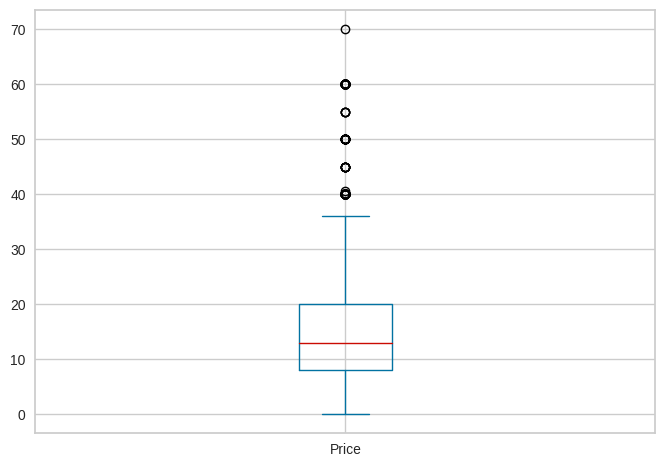

In [49]:
games_feat['Price'].plot(kind='box')
plt.show()

Text(0.5, 1.0, 'Histogram of price of Steam games')

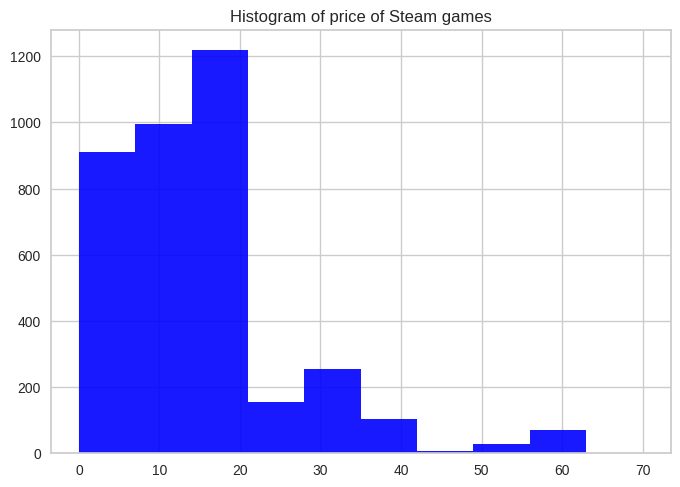

In [50]:
plt.hist(games_feat.Price, facecolor='blue', alpha=0.9)
plt.title('Histogram of price of Steam games')

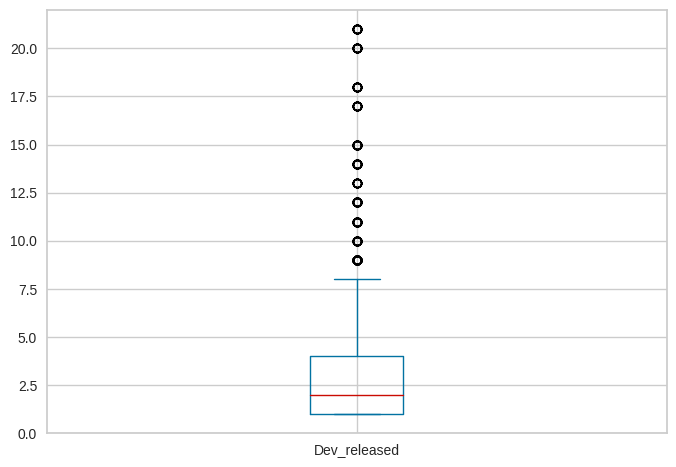

In [51]:
games_feat['Dev_released'].plot(kind='box')
plt.show()

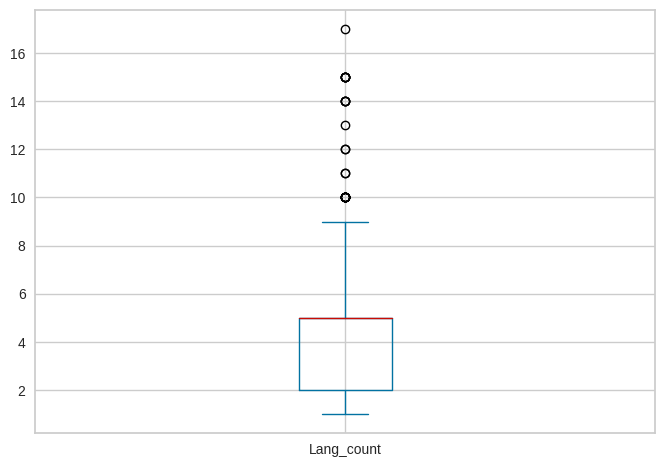

In [52]:
games_feat['Lang_count'].plot(kind='box')
plt.show()

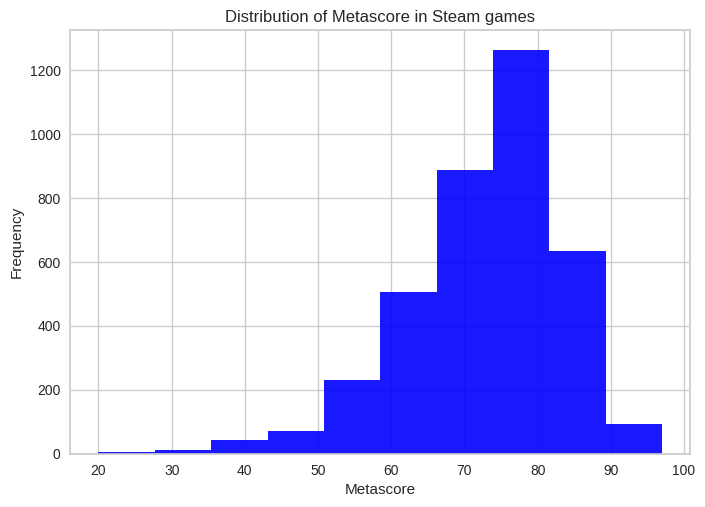

In [54]:
plt.hist(games_feat['Metacritic_score'], facecolor='blue', alpha=0.9)
plt.xlabel('Metascore')  # Add x label
plt.ylabel('Frequency')   # Add y label
plt.title('Distribution of Metascore in Steam games')  # Add title

# Save the plot to a PNG file
plt.savefig('metascore_distribution.png')

# Display the plot
plt.show()

In [55]:
ss = games_feat[games_feat['Linux'] == 1]
ss1 = games_feat[games_feat['Mac'] == 1]

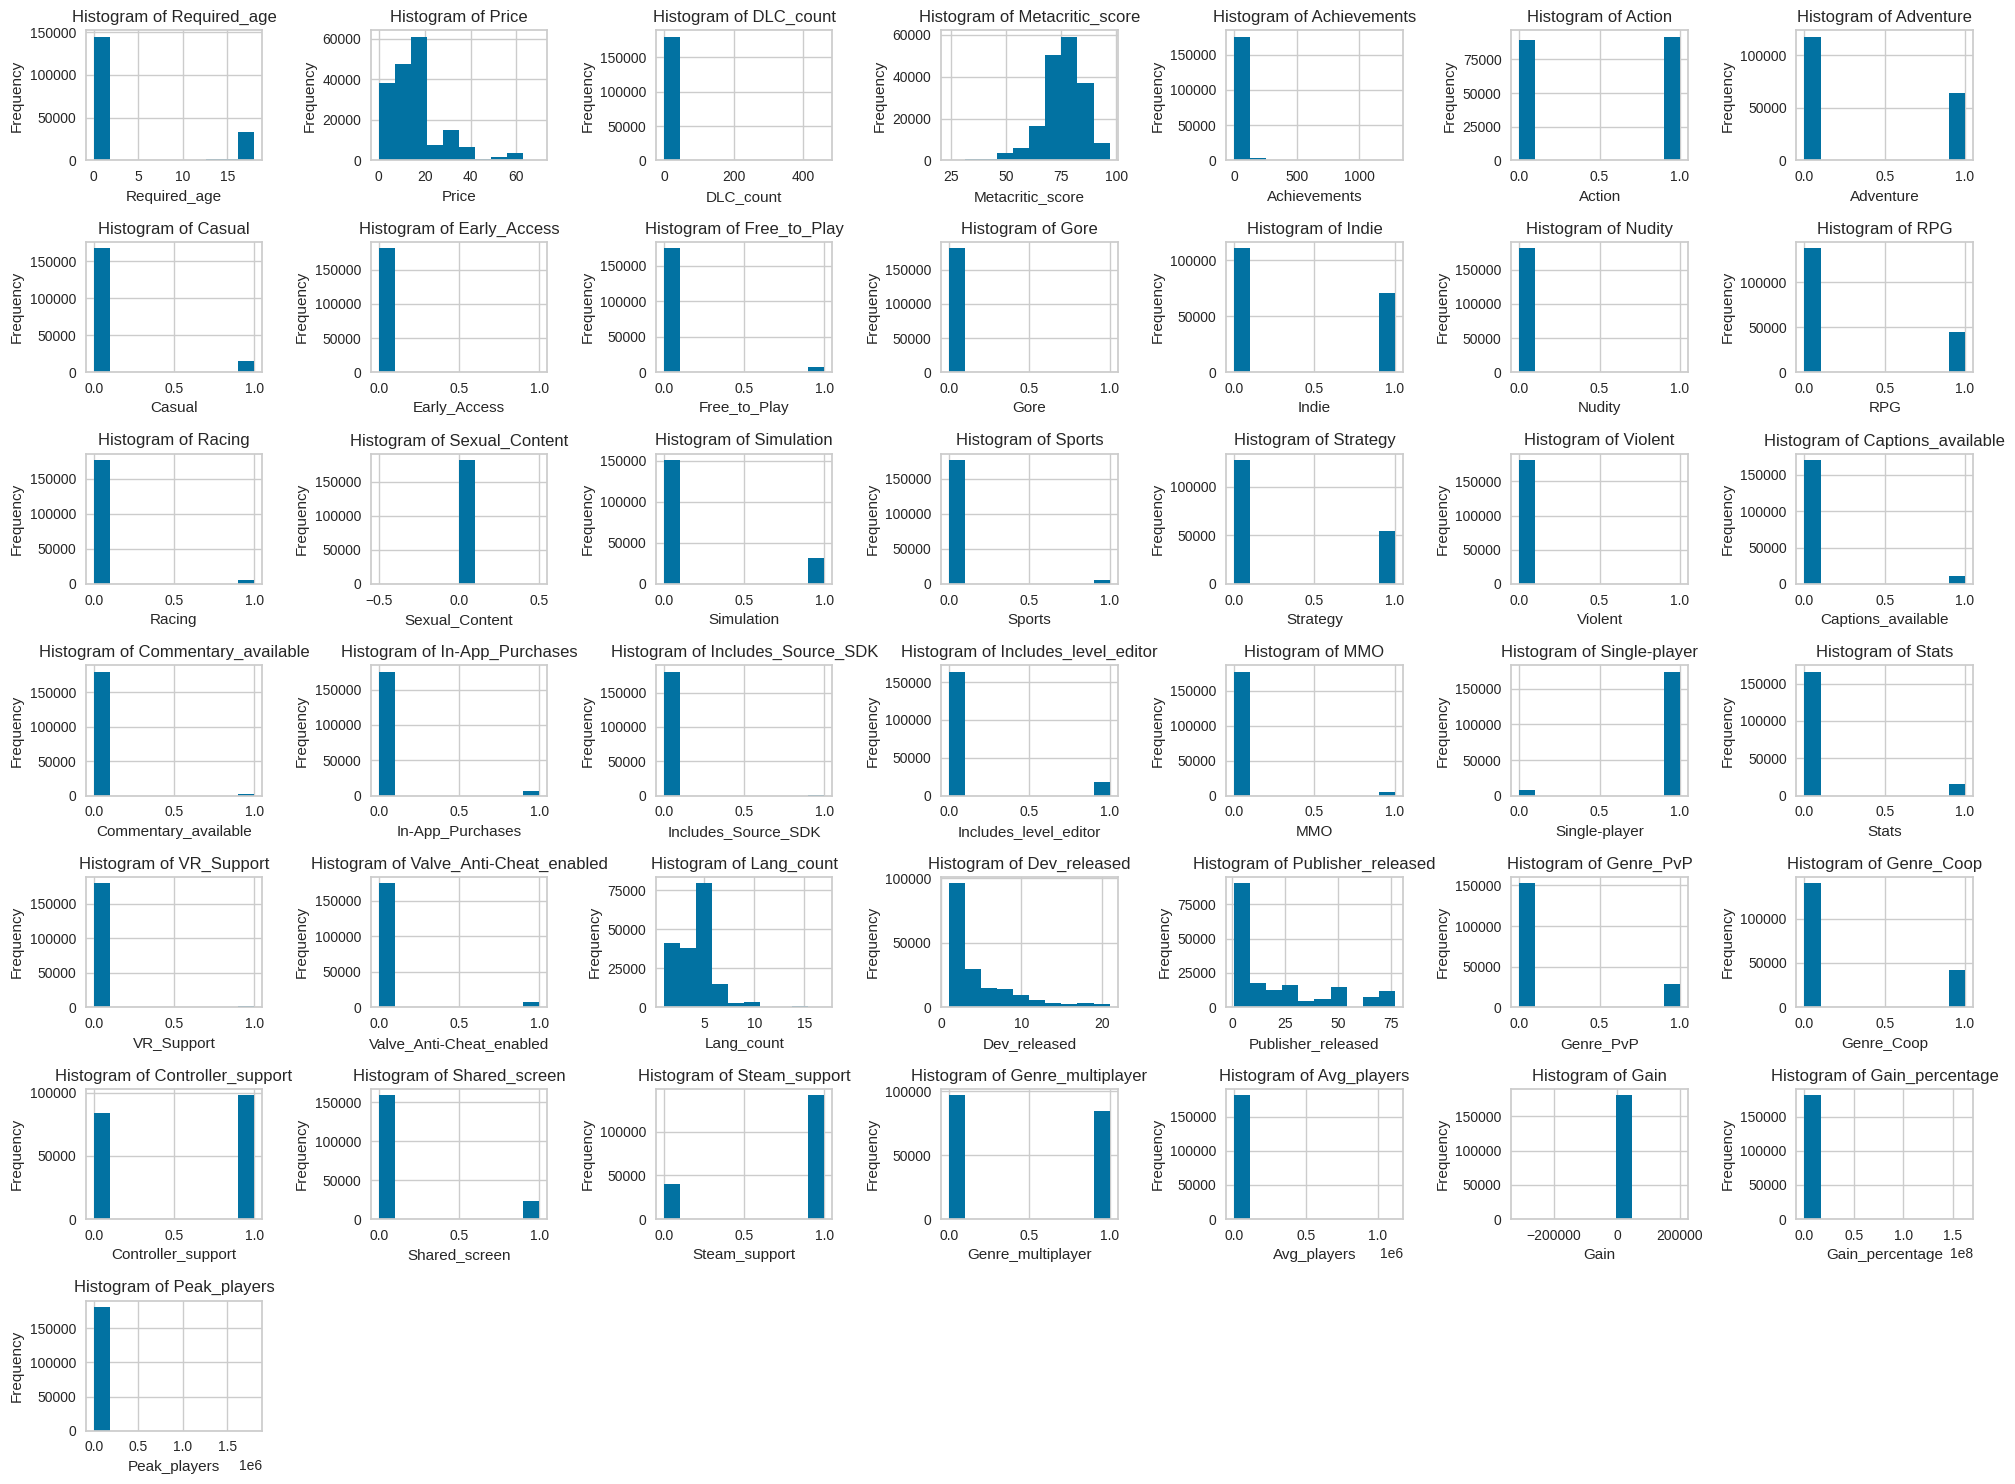

In [58]:
# Filter the columns based on data types
numeric_columns = merged_data.drop(columns='AppID').select_dtypes(include=[np.number]).columns

# Calculate the number of rows and columns for the grid
num_plots = len(numeric_columns)
num_rows = int(np.ceil(np.sqrt(num_plots)))
num_cols = int(np.ceil(num_plots / num_rows))

# Create the grid of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 15))

# Plot the numeric columns in the grid
for i, column in enumerate(numeric_columns):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]
    merged_data[column].plot(kind='hist', ax=ax)
    ax.set_title(f'Histogram of {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')

# Remove any empty subplots
if num_plots < num_rows * num_cols:
    for i in range(num_plots, num_rows * num_cols):
        row = i // num_cols
        col = i % num_cols
        fig.delaxes(axes[row, col])

# Adjust the spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()

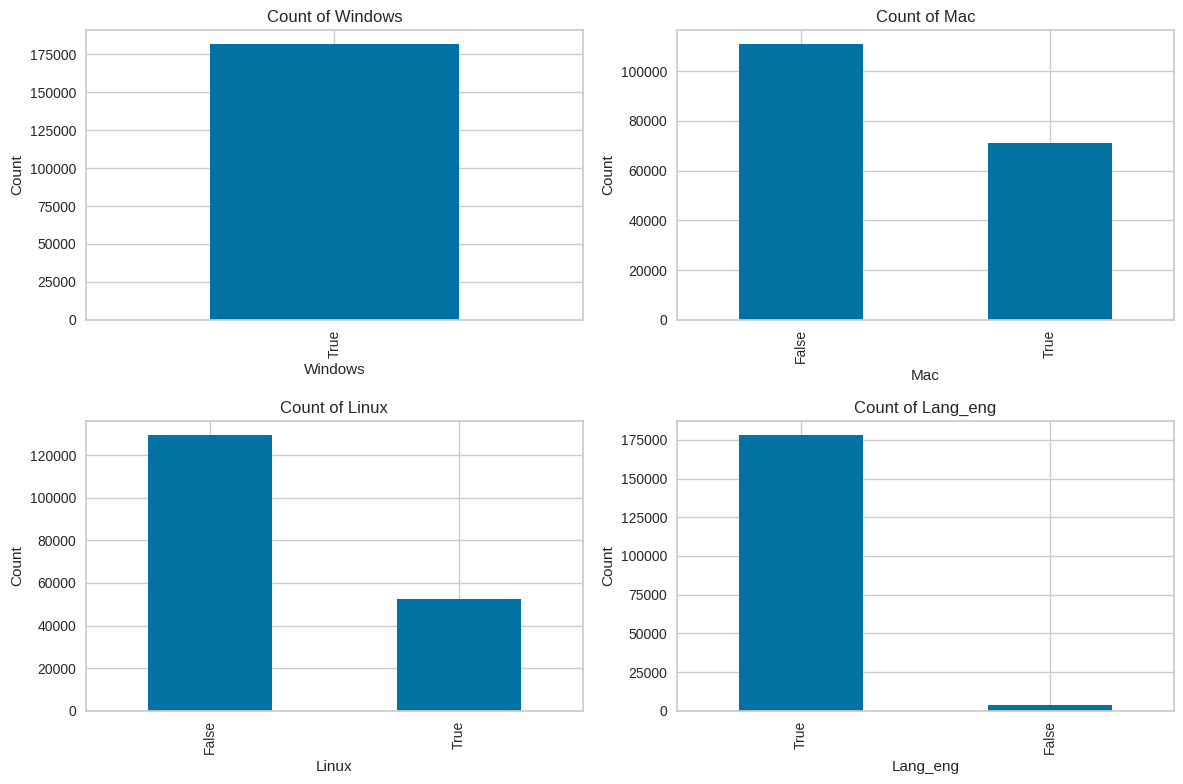

In [59]:
# Filter the columns based on data types
object_columns = merged_data.drop(columns=['Name_x', 'Name_y']).select_dtypes(include=['bool']).columns

# Calculate the number of subplots needed
num_plots = len(object_columns)
num_cols = 2  
num_rows = (num_plots + num_cols - 1) // num_cols  

# Create subplots for the object columns
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

# Plot the object columns in the subplots
for i, column in enumerate(object_columns):
    row = i // num_cols
    col = i % num_cols
    merged_data[column].value_counts().plot(kind='bar', ax=axes[row, col])
    axes[row, col].set_title(f'Count of {column}')
    axes[row, col].set_xlabel(column)
    axes[row, col].set_ylabel('Count')

# Adjust the layout and display the subplots
plt.tight_layout()
plt.show()

#### Removing low variance features

In [46]:
# Copy merged df and remove and unwanted colmns that are not revelant for model training
merged_fortrain = merged_data.copy()
merged_fortrain.reset_index(drop=True)

merged_fortrain = merged_fortrain.drop(columns=['Name_x', 'Name_y', 'AppID'])

In [47]:
# Calculate the number of unique values in each column
unique_counts = merged_fortrain.nunique()

# Get the column names where the count is equal to 1
single_value_columns = unique_counts[unique_counts == 1].index

# Drop the columns from the DataFrame
merged_fortrain.drop(single_value_columns, axis=1, inplace=True)

In [48]:
# Remove uncommon user-generated game tags
threshold = 0.05 

# # Calculate the imbalance ratio for each feature
imbalance_ratio = merged_fortrain.select_dtypes(include=[np.number, 'bool']).sum() / len(merged_fortrain)

# # Get the column names where the imbalance ratio is below the threshold
imbalanced_columns = imbalance_ratio[imbalance_ratio < threshold].index

# # Drop the imbalanced columns from the DataFrame
merged_fortrain.drop(imbalanced_columns, axis=1, inplace=True)

#### Encoding

In [49]:
# Label encode categorical features
Label_encoder = LabelEncoder()
data_encoded = merged_fortrain.copy()

releaseDate_encoded = Label_encoder.fit_transform(merged_fortrain['Release_date'])
data_encoded['Release_date'] = releaseDate_encoded

Month_encoded = Label_encoder.fit_transform(merged_fortrain['Month'])
data_encoded['Month'] = Month_encoded

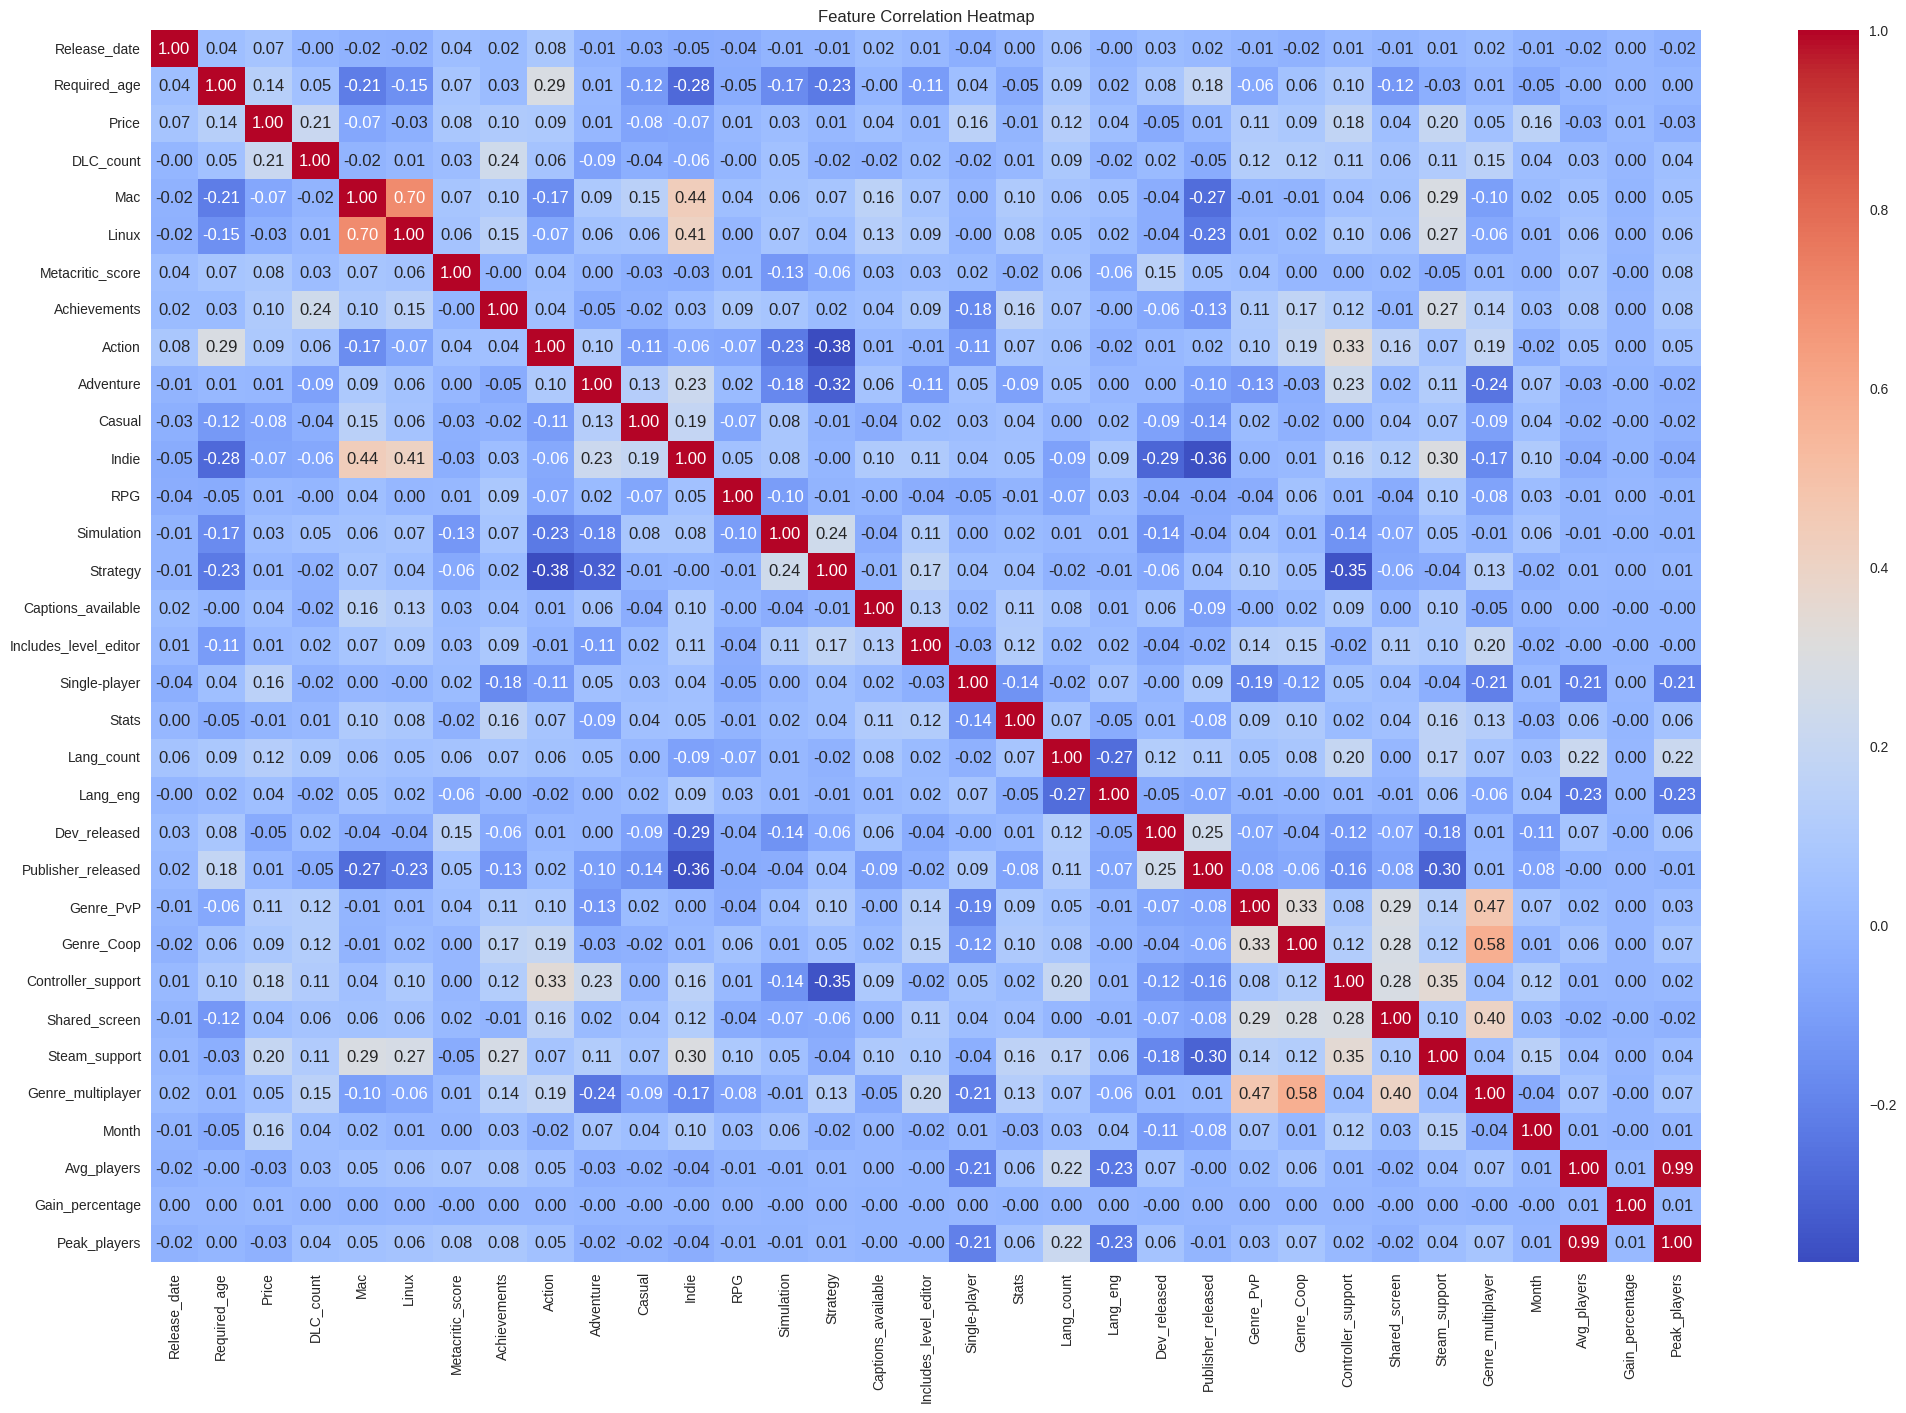

In [64]:
# Calculate the correlation matrix
correlation_matrix = data_encoded.corr()

# Create a heatmap
plt.figure(figsize=(25, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()

In [50]:
# Drop features with high correlation with each other with to target variable
df_fortrain = data_encoded.copy()
df_fortrain.drop(['Peak_players'], axis=1, inplace=True) 


In [51]:
print(df_fortrain.columns)
print(df_fortrain.shape)


Index(['Release_date', 'Required_age', 'Price', 'DLC_count', 'Mac', 'Linux',
       'Metacritic_score', 'Achievements', 'Action', 'Adventure', 'Casual',
       'Indie', 'RPG', 'Simulation', 'Strategy', 'Captions_available',
       'Includes_level_editor', 'Single-player', 'Stats', 'Lang_count',
       'Lang_eng', 'Dev_released', 'Publisher_released', 'Genre_PvP',
       'Genre_Coop', 'Controller_support', 'Shared_screen', 'Steam_support',
       'Genre_multiplayer', 'Month', 'Avg_players', 'Gain_percentage'],
      dtype='object')
(181784, 32)


## Model training

#### Make data split

In [52]:
# Make train / test split
df = df_fortrain.copy()

# Split df into X (independent) and y (target)
y = df['Metacritic_score']
X = df.drop('Metacritic_score', axis=1)

# 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=87789)

# Print the sizes of the three sets
print("Training set size:", X_train.shape[0])
print("Testing set size:", X_test.shape[0])

# Scale X data using StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)


Training set size: 145427
Testing set size: 36357


#### Get feature importance

In [53]:
from sklearn.feature_selection import SelectKBest, f_regression

# Create and fit the selector object on the training data
selector = SelectKBest(score_func=f_regression, k=30)
selector.fit(X_train, y_train)

# Get the F-statistics and p-values of the selected features
feature_scores = selector.scores_
feature_pvalues = selector.pvalues_

# Create a DataFrame to store the features, F-statistics, and p-values
feature_stats_df = pd.DataFrame({'Feature': X_train.columns, 'F-statistic': feature_scores, 'P-value': feature_pvalues})

# Sort the DataFrame by F-statistic in descending order
feature_stats_df = feature_stats_df.sort_values(by='F-statistic', ascending=False)

# Print the DataFrame
print(feature_stats_df.head(30))



               Feature  F-statistic        P-value
20        Dev_released  3207.761878   0.000000e+00
12          Simulation  2389.264769   0.000000e+00
2                Price   997.788999  2.994039e-218
4                  Mac   746.799759  5.191898e-164
29         Avg_players   738.556443  3.152361e-162
..                 ...          ...            ...
24  Controller_support     2.836648   9.213837e-02
8            Adventure     2.474507   1.157079e-01
28               Month     2.188846   1.390156e-01
6         Achievements     1.209141   2.715042e-01
30     Gain_percentage     0.501789   4.787165e-01

[30 rows x 3 columns]


In [69]:
# Export F-test and p-values of features to latex
feature_stats_df.to_latex('feature_scores')

In [54]:
# Select to features based if p-value is < 0.05
top_features = feature_stats_df.Feature[feature_stats_df['P-value'] < 0.05]
top_features

20         Dev_released
12           Simulation
2                 Price
4                   Mac
29          Avg_players
            ...        
16        Single-player
17                Stats
25        Shared_screen
27    Genre_multiplayer
11                  RPG
Name: Feature, Length: 25, dtype: object

In [55]:
# Set random state
rs = 678678

#### Make split based on feature importance


In [56]:
# Make train / test split
df = df_fortrain.copy()

# Split df into X (independent) and y (target)
y = df['Metacritic_score']
X = df[top_features]


# Split the data into training and the remaining data
X_train, X_remaining, y_train, y_remaining = train_test_split(X, y, test_size=0.4, random_state=rs)

# Split the remaining data into two equal parts for validation and testing
X_val_test, X_test, y_val_test, y_test = train_test_split(X_remaining, y_remaining, test_size=0.5, random_state=rs)

# Split the validation and testing data into two equal parts for validation1 and validation2
X_val1, X_val2, y_val1, y_val2 = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=rs)


# Print the sizes of the three sets
print("Training set size:", X_train.shape[0])
print("Validation1  size:", X_val1.shape[0])
print("Testing set  size:", X_test.shape[0])
print("Validation2  size:", X_val2.shape[0])



Training set size: 109070
Validation1  size: 18178
Testing set  size: 36357
Validation2  size: 18179


In [57]:
df_fortrain.shape

(181784, 32)

In [58]:
# Scale X data using StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
X_val1 = pd.DataFrame(scaler.transform(X_val1), index=X_val1.index, columns=X_val1.columns)
X_val2 = pd.DataFrame(scaler.transform(X_val2), index=X_val2.index, columns=X_val2.columns)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

In [59]:
X_train

,Dev_released,Simulation,Price,Mac,Avg_players,Required_age,Lang_count,Linux,Lang_eng,Strategy,Publisher_released,Steam_support,Genre_PvP,Action,Release_date,Indie,Casual,DLC_count,Captions_available,Includes_level_editor,Single-player,Stats,Shared_screen,Genre_multiplayer,RPG
180851,-0.051262,-0.452997,-0.513936,-0.799401,-0.079844,2.005046,-1.526672,-0.636451,0.143144,-0.651940,-0.702351,-1.895317,-0.437400,0.987300,0.216534,-0.801405,-0.294561,-0.259173,-0.258323,-0.329688,0.208429,-0.306779,-0.377984,1.070608,-0.565329
94684,-0.737203,-0.452997,0.744526,1.250937,-0.075314,-0.505625,0.386536,1.571212,0.143144,-0.651940,-0.830890,0.527616,2.286237,0.987300,-1.305638,1.247809,-0.294561,0.167948,-0.258323,-0.329688,0.208429,-0.306779,2.645613,1.070608,-0.565329
36795,-0.508556,-0.452997,0.325038,-0.799401,-0.072402,-0.505625,0.386536,-0.636451,0.143144,-0.651940,1.954109,0.527616,-0.437400,0.987300,-0.044899,-0.801405,-0.294561,0.765919,-0.258323,-0.329688,0.208429,-0.306779,-0.377984,1.070608,-0.565329
54632,-0.508556,-0.452997,0.325038,-0.799401,-0.083080,2.005046,0.386536,-0.636451,0.143144,-0.651940,-0.616659,0.527616,-0.437400,0.987300,1.555459,-0.801405,-0.294561,-0.259173,-0.258323,-0.329688,0.208429,-0.306779,-0.377984,1.070608,-0.565329
52760,-0.051262,-0.452997,2.002988,1.250937,-0.051801,-0.505625,0.386536,1.571212,0.143144,1.533885,-0.659505,0.527616,-0.437400,-1.012864,1.230500,-0.801405,-0.294561,-0.088325,-0.258323,-0.329688,0.208429,-0.306779,-0.377984,1.070608,-0.565329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164051,-0.508556,-0.452997,-0.513936,1.250937,-0.081894,2.005046,-1.048370,-0.636451,0.143144,-0.651940,-0.573813,0.527616,-0.437400,0.987300,0.431543,-0.801405,-0.294561,-0.259173,-0.258323,-0.329688,0.208429,-0.306779,-0.377984,1.070608,1.768880
171322,-0.051262,2.207518,1.164013,-0.799401,-0.082649,-0.505625,-1.526672,-0.636451,0.143144,-0.651940,-0.745198,0.527616,-0.437400,0.987300,-1.462009,-0.801405,-0.294561,-0.259173,3.871129,-0.329688,0.208429,-0.306779,-0.377984,-0.934048,-0.565329
129483,-0.737203,-0.452997,-0.094449,1.250937,-0.082487,-0.505625,0.386536,1.571212,0.143144,-0.651940,-0.830890,0.527616,-0.437400,-1.012864,0.221420,1.247809,-0.294561,-0.088325,-0.258323,-0.329688,0.208429,-0.306779,-0.377984,-0.934048,-0.565329
13315,-0.737203,-0.452997,-0.094449,1.250937,-0.082864,-0.505625,-1.526672,-0.636451,0.143144,-0.651940,-0.488121,0.527616,-0.437400,0.987300,-0.841413,1.247809,-0.294561,-0.002900,-0.258323,-0.329688,0.208429,-0.306779,-0.377984,-0.934048,-0.565329


##### Initialize models

In [60]:
# initialize models


models = {
    "Linear Regression": LinearRegression(n_jobs=-1),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(n_jobs=-1, random_state=rs),
    "Gradient Boosting": GradientBoostingRegressor(),
    "XGBoost": XGBRegressor(n_jobs=-1, random_state=rs),
    "LightGBM": LGBMRegressor(n_jobs=-1, force_col_wise=True, random_state=rs)
}



#### Training

In [61]:
from sklearn.model_selection import cross_val_score

def cv_comparison(models, X, y, cv):
    # Initiate a DataFrame for the averages and a list for all measures
    cv_accuracies = pd.DataFrame()
    maes = []
    mses = []
    r2s = []
    accs = []
    # Loop through the models, run a CV, add the average scores to the DataFrame and the scores of 
    # all CVs to the list
    for model in models:
        mae = -np.round(cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv), 4)
        maes.append(mae)
        mae_avg = round(mae.mean(), 4)
        mse = -np.round(cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=cv), 4)
        mses.append(mse)
        mse_avg = round(mse.mean(), 4)
        r2 = np.round(cross_val_score(model, X, y, scoring='r2', cv=cv), 4)
        r2s.append(r2)
        r2_avg = round(r2.mean(), 4)
        cv_accuracies[str(model)] = [mae_avg, mse_avg, r2_avg]
    cv_accuracies.index = ['Mean Absolute Error', 'Root Mean Squared Error', 'R^2']
    return cv_accuracies, maes, mses, r2s

In [ ]:
comp, maes, mses, r2s = cv_comparison(list(models.values()), X_train, y_train, 5)


In [ ]:
results_cv = comp.transpose()
results_cv

,Mean Absolute Error,Root Mean Squared Error,R^2
LinearRegression(n_jobs=-1),6.8575,8.9509,0.0731
DecisionTreeRegressor(),0.1335,1.2760,0.9808
"RandomForestRegressor(n_jobs=-1, random_state=678678)",0.1611,0.9879,0.9887
GradientBoostingRegressor(),5.5639,7.2959,0.3841
"XGBRegressor(base_score=None, booster=None, callbacks=None,\n colsample_bylevel=None, colsample_bynode=None,\n colsample_bytree=None, device=None, early_stopping_rounds=None,\n enable_categorical=False, eval_metric=None, feature_types=None,\n gamma=None, grow_policy=None, importance_type=None,\n interaction_constraints=None, learning_rate=None, max_bin=None,\n max_cat_threshold=None, max_cat_to_onehot=None,\n max_delta_step=None, max_depth=None, max_leaves=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n multi_strategy=None, n_estimators=None, n_jobs=-1,\n num_parallel_tree=None, random_state=678678, ...)",1.5492,2.2587,0.9410
"LGBMRegressor(force_col_wise=True, n_jobs=-1, random_state=678678)",3.5530,4.5893,0.7563


In [ ]:
# Create DataFrame for all R^2s
r2_comp = pd.DataFrame(r2s, index=comp.columns, columns=['1st Fold', '2nd Fold', '3rd Fold', 
                                                         '4th Fold', '5th fold'])

# Add a column for the averages
r2_comp['Average'] = np.round(r2_comp.mean(axis=1),4)

In [ ]:
r2_comp

,1st Fold,2nd Fold,3rd Fold,4th Fold,5th fold,Average
LinearRegression(n_jobs=-1),0.0764,0.0742,0.0738,0.0702,0.0708,0.0731
DecisionTreeRegressor(),0.9822,0.9809,0.9833,0.9809,0.9765,0.9808
"RandomForestRegressor(n_jobs=-1, random_state=678678)",0.9878,0.9892,0.9904,0.9893,0.9867,0.9887
GradientBoostingRegressor(),0.3832,0.3856,0.3863,0.3862,0.3794,0.3841
"XGBRegressor(base_score=None, booster=None, callbacks=None,\n colsample_bylevel=None, colsample_bynode=None,\n colsample_bytree=None, device=None, early_stopping_rounds=None,\n enable_categorical=False, eval_metric=None, feature_types=None,\n gamma=None, grow_policy=None, importance_type=None,\n interaction_constraints=None, learning_rate=None, max_bin=None,\n max_cat_threshold=None, max_cat_to_onehot=None,\n max_delta_step=None, max_depth=None, max_leaves=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n multi_strategy=None, n_estimators=None, n_jobs=-1,\n num_parallel_tree=None, random_state=678678, ...)",0.9420,0.9397,0.9436,0.9392,0.9403,0.9410
"LGBMRegressor(force_col_wise=True, n_jobs=-1, random_state=678678)",0.7522,0.7582,0.7597,0.7513,0.7602,0.7563


In [ ]:
results_cv.to_latex('results_cv')
r2_comp.to_latex('results_cv-folds')

##### Experimenting on different hyperparameters (takes a while, don't run)

In [ ]:
# from sklearn.model_selection import RandomizedSearchCV
# from scipy.stats import randint, uniform

# # Define the hyperparameter grids for each model
# param_distributions = {
#     "Linear Regression": {'fit_intercept': [True, False],
#                                  'copy_X': [True, False],
#                             },

#     "Decision Tree":         {'max_depth': [None, 10, 20 , 30, 40],
#                       'min_samples_split': [2, 4, 6, 8, 10, 12],
#                             },

#     "Random Forest":      {'n_estimators': [100, 200, 400, 600, 800],
#                               'max_features': [0.6, 0.7, 0.8, 0.9, 1.0]}, 

#     "Gradient Boosting": {'learning_rate': [0.05, 0.1, 0.2, 0.3, 0.4],
#                             'max_depth':   [3, 10, 15, 20, 25],
#                             }, 

#     "XGBoost": {          'learning_rate': [0.05, 0.1, 0.2, 0.3, 0.4],
#                                   'gamma': [0, 0.1, 0.2, 1, 1.5, 2], 
#                             }, 

#     "LightGBM": {         'learning_rate': [0.05, 0.1, 0.2, 0.3, 0.4],
#                              'num_leaves': [3, 7, 15, 31, 127], 
#                             }           
# }

# # Create a dictionary to store the best estimators after hyperparameter tuning
# best_estimators = {}
# estimators = {}
# best_score = {}
# best_index = {}

# # Perform random search for each model
# for name, model in models.items():
#     random_search = RandomizedSearchCV(model, param_distributions[name], n_iter=60, scoring=['neg_mean_absolute_error', 'neg_root_mean_squared_error', 'r2'], refit='neg_root_mean_squared_error', n_jobs=-1, cv=5, random_state=5678)
#     random_search.fit(X_val1, y_val1)
#     best_estimators[name] = random_search.best_estimator_
#     estimators[name] = random_search.cv_results_
#     best_score[name] = random_search.best_score_
#     best_index[name] = random_search.best_index_
    
# # Access the best hyperparameters and models
# for name, estimator in best_estimators.items():
#     print(f"Best hyperparameters for {name}: {estimator.get_params()}")

/home/arvind/.local/lib/python3.11/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=60. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [ ]:
# Create a dictionary to store the scores
scores_data = {'Model': [], 'MAE': [], 'RMSE': [], 'R^2': []}

# Populate the dictionary with the scores
for model, index in best_index.items():
    scores_data['Model'].append(model)
    scores_data['MAE'].append(round(abs(estimators[model]["mean_test_neg_mean_absolute_error"][index]), 4))
    scores_data['RMSE'].append(round(abs(estimators[model]["mean_test_neg_root_mean_squared_error"][index]), 4))
    scores_data['R^2'].append(round(abs(estimators[model]["mean_test_r2"][index]), 4))

# Create a DataFrame from the scores data
hp_scores = pd.DataFrame(scores_data)

# Print the DataFrame
print(hp_scores)

hp_scores.to_latex('results_hp')

               Model     MAE    RMSE     R^2
0  Linear Regression  6.8405  8.9256  0.0678
1      Decision Tree  0.6497  3.0027  0.8940
2      Random Forest  0.8532  2.0325  0.9516
3  Gradient Boosting  0.8060  1.8135  0.9615
4            XGBoost  1.5085  2.3327  0.9362
5           LightGBM  1.1596  2.0712  0.9497


#### Train models on test set using best hyperparameters and make error pattern plots

/home/arvind/.local/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


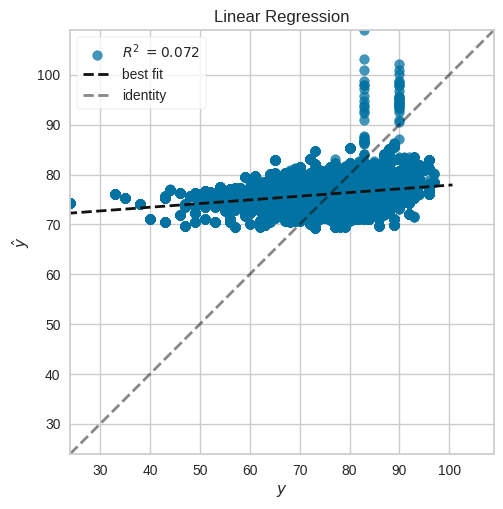

/home/arvind/.local/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


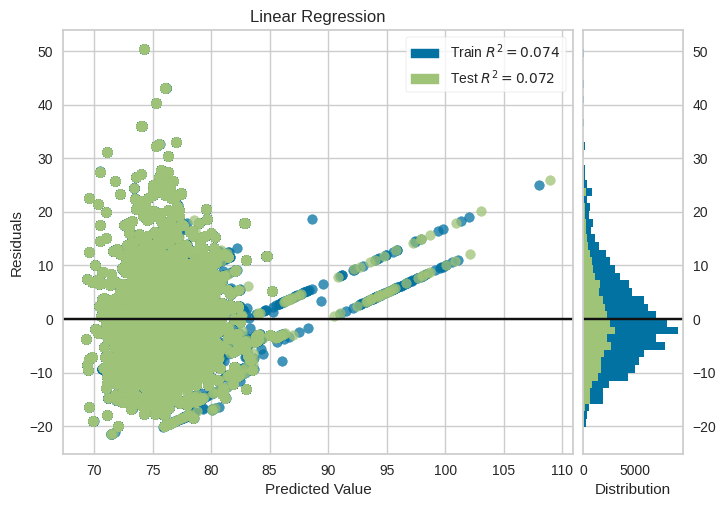

/home/arvind/.local/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


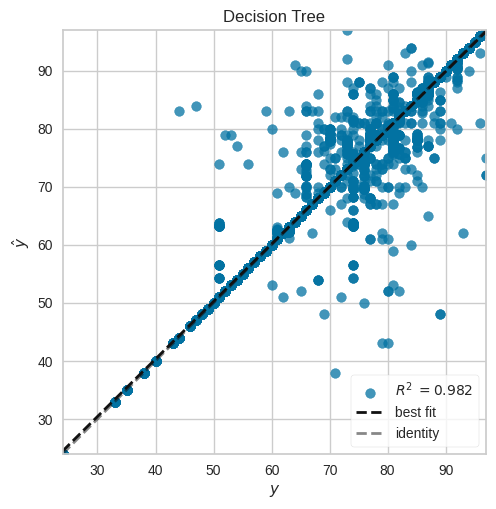

/home/arvind/.local/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


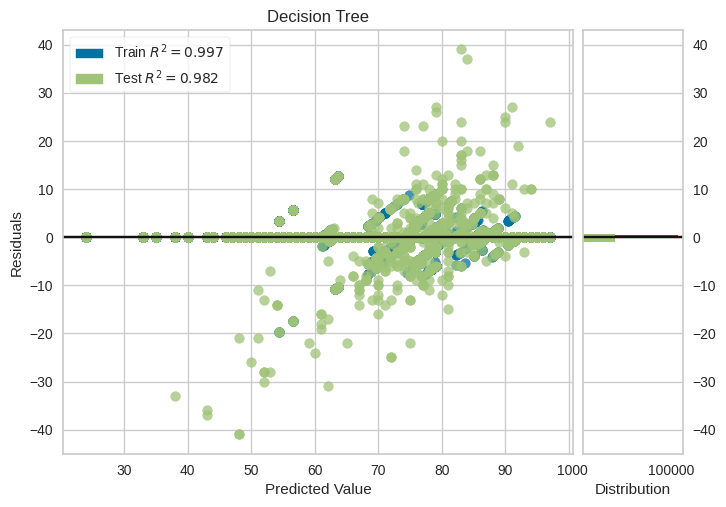

/home/arvind/.local/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


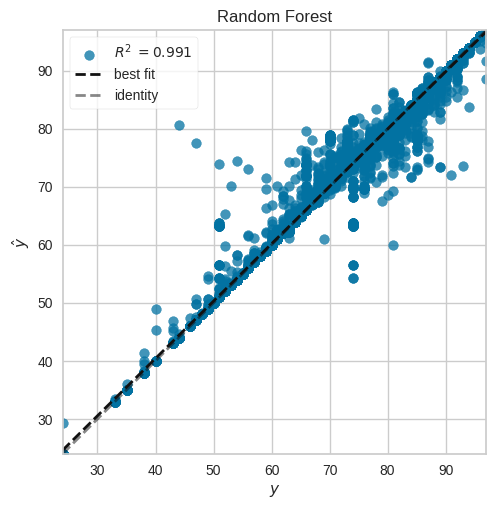

/home/arvind/.local/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


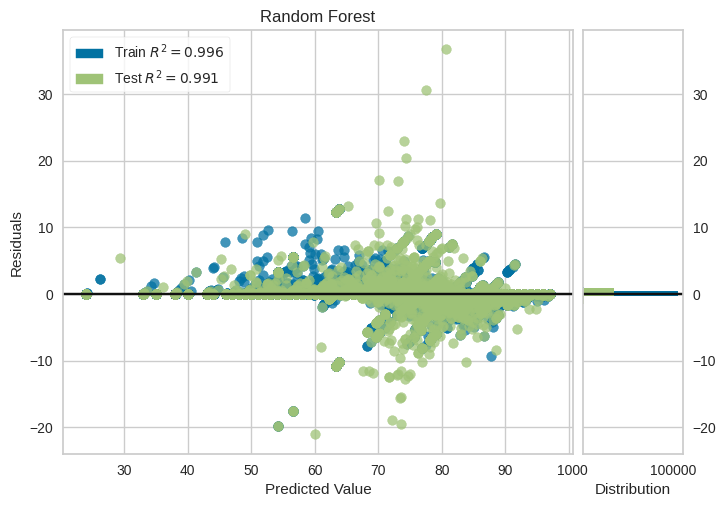

/home/arvind/.local/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


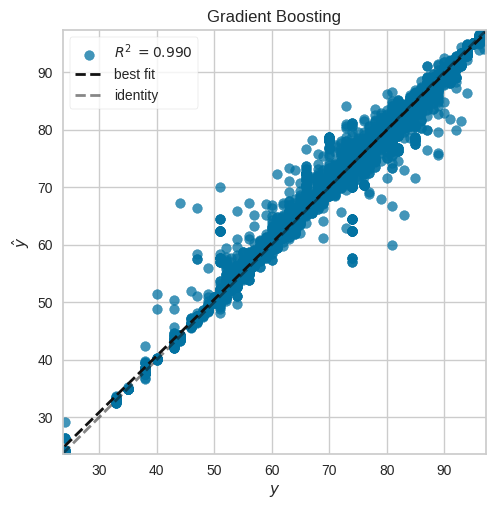

/home/arvind/.local/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


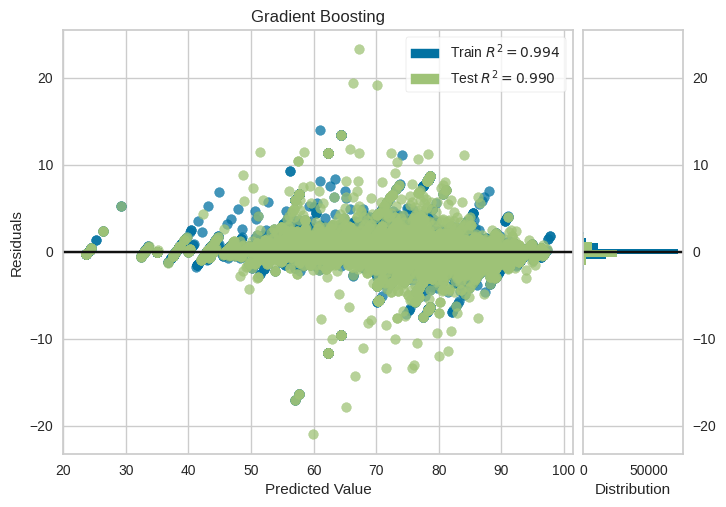

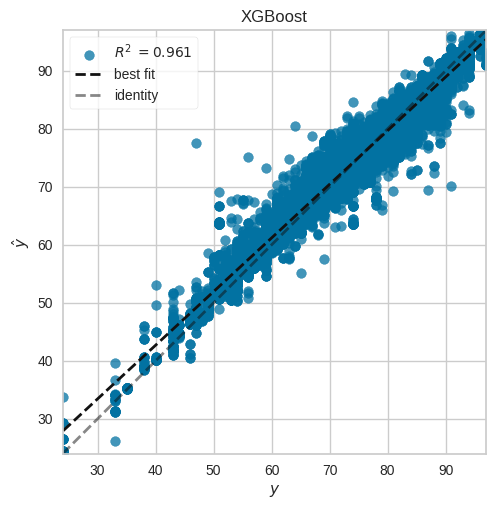

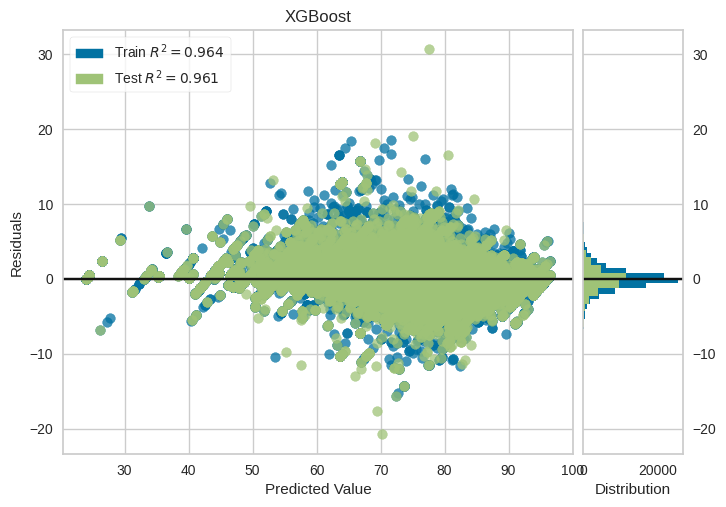

[LightGBM] [Info] Total Bins 790
[LightGBM] [Info] Number of data points in the train set: 109070, number of used features: 25
[LightGBM] [Info] Start training from score 76.113780


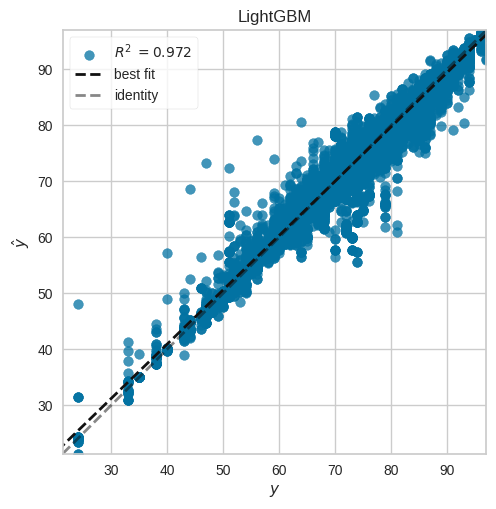

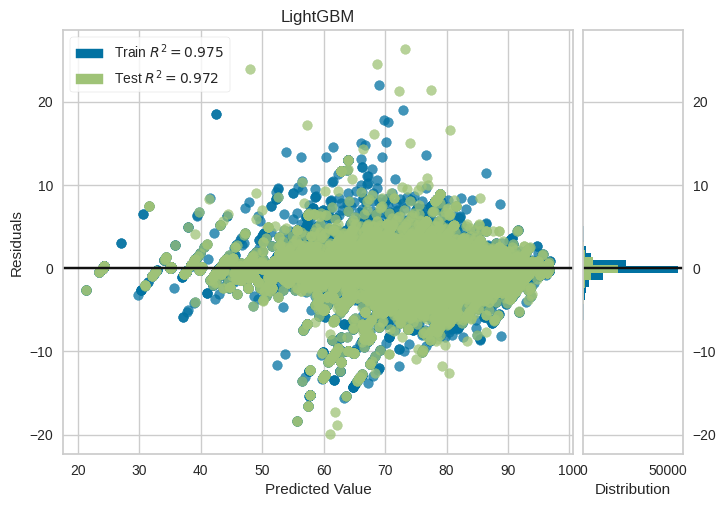

               Model       MAE      RMSE       R^2
0  Linear Regression  6.888228  8.979540  0.072498
1      Decision Tree  0.126032  1.243017  0.982227
2      Random Forest  0.129087  0.880873  0.991074
3  Gradient Boosting  0.412858  0.948323  0.989655
4            XGBoost  1.228605  1.845522  0.960822
5           LightGBM  0.792643  1.561238  0.971962


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from yellowbrick.regressor import PredictionError, ResidualsPlot
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

best_estimators = {
    "Linear Regression": LinearRegression(n_jobs=-1),
    "Decision Tree": DecisionTreeRegressor(max_depth=30, min_samples_split=2),
    "Random Forest": RandomForestRegressor(n_jobs=-1, random_state=rs, n_estimators=800, max_features=0.6),
    "Gradient Boosting": GradientBoostingRegressor(learning_rate=0.2, max_depth=10),
    "XGBoost": XGBRegressor(n_jobs=-1, random_state=rs, learning_rate=0.4, gamma=2),
    "LightGBM": LGBMRegressor(n_jobs=-1, random_state=rs, learning_rate=0.3, num_leaves=127)
}

results_test = []

for name, estimator in best_estimators.items():
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results_test.append({'Model': name, 'MAE': mae, 'RMSE': rmse, 'R^2': r2})

    # Create a PredictionError visualizer
    visualizer_pe = PredictionError(estimator, title=name)
    visualizer_pe.fit(X_train, y_train)  
    visualizer_pe.score(X_test, y_test)  
    visualizer_pe.show()  

    # Create a ResidualsPlot visualizer
    visualizer_rp = ResidualsPlot(estimator, title=name)
    visualizer_rp.fit(X_train, y_train)  
    visualizer_rp.score(X_test, y_test)  
    visualizer_rp.show() 

final_results = pd.DataFrame(results_test)
print(final_results)


In [ ]:
# Save results on test set to latex table
final_results = final_results.round(decimals=4)
final_results = final_results.reset_index(drop=True)
final_results.to_latex('results_final')

## Feature importance

##### Recursive feature elimination

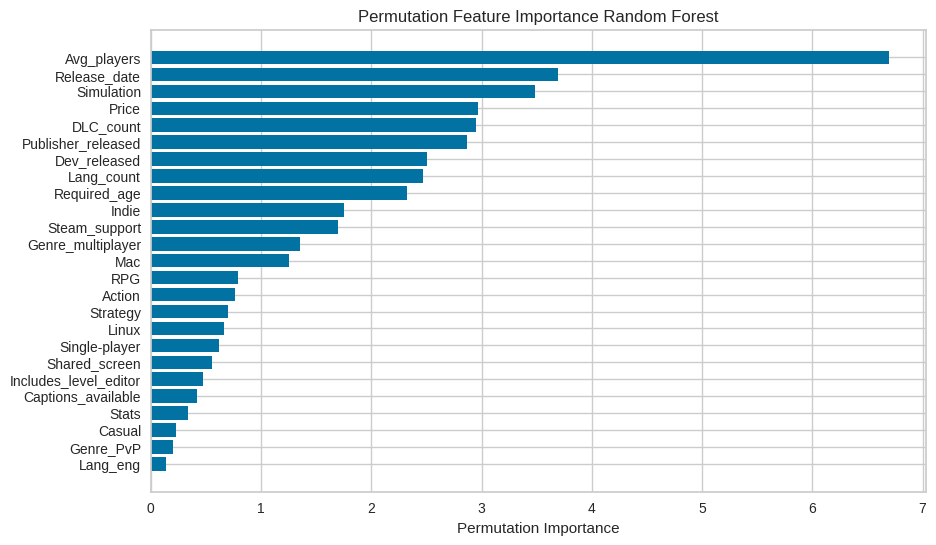

In [63]:
from sklearn.inspection import permutation_importance

# Create the RandomForestRegressor model
model_pmi1 = RandomForestRegressor(n_jobs=-1, random_state=rs, n_estimators=800, max_features=0.6)

# Fit the model on the entire training data
model_pmi1.fit(X_val2, y_val2)

# Calculate permutation importance
rf_importance = permutation_importance(model_pmi1, X_val2, y_val2, n_repeats=30, random_state=rs, n_jobs=-1, scoring='neg_root_mean_squared_error')

# Plot the feature importances
sorted_idx = rf_importance.importances_mean.argsort()
plt.figure(figsize=(10, 6))
plt.barh(X.columns[sorted_idx], rf_importance.importances_mean[sorted_idx])
plt.xlabel('Permutation Importance')
plt.title('Permutation Feature Importance Random Forest')
plt.show()

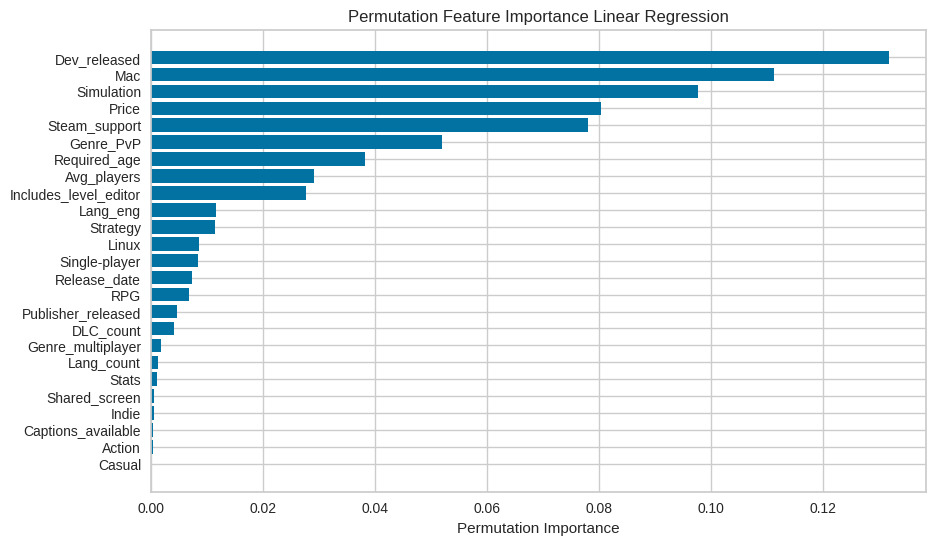

In [220]:
from sklearn.inspection import permutation_importance

# Create the RandomForestRegressor model
model_pmi2 = LinearRegression(n_jobs=-1)

# Fit the model on the entire training data
model_pmi2.fit(X_val2, y_val2)

# Calculate permutation importance
lr_importance = permutation_importance(model_pmi2, X_val2, y_val2, n_repeats=30, random_state=123123, scoring='neg_root_mean_squared_error')

# Plot the feature importances
sorted_idx = perm_importance.importances_mean.argsort()
plt.figure(figsize=(10, 6))
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel('Permutation Importance')
plt.title('Permutation Feature Importance Linear Regression')
plt.show()

## Player count and Metascore correlation

#### Create average player count df

In [64]:
data_pc = merged_data.copy()
data_pc.columns

Index(['AppID', 'Name_x', 'Release_date', 'Required_age', 'Price', 'DLC_count',
       'Windows', 'Mac', 'Linux', 'Metacritic_score', 'Achievements', 'Action',
       'Adventure', 'Casual', 'Early_Access', 'Free_to_Play', 'Gore', 'Indie',
       'Nudity', 'RPG', 'Racing', 'Sexual_Content', 'Simulation', 'Sports',
       'Strategy', 'Violent', 'Captions_available', 'Commentary_available',
       'In-App_Purchases', 'Includes_Source_SDK', 'Includes_level_editor',
       'MMO', 'Single-player', 'Stats', 'VR_Support',
       'Valve_Anti-Cheat_enabled', 'Lang_count', 'Lang_eng', 'Dev_released',
       'Publisher_released', 'Genre_PvP', 'Genre_Coop', 'Controller_support',
       'Shared_screen', 'Steam_support', 'Genre_multiplayer', 'Name_y',
       'Month', 'Avg_players', 'Gain', 'Gain_percentage', 'Peak_players'],
      dtype='object')

In [65]:
pc_grouped = data_pc.groupby('AppID') \
       .agg({'Avg_players':'mean'}) \
       .reset_index()

In [66]:
pc_merged = pd.merge(pc_grouped, games_feat, on='AppID')

In [67]:
X_pdp = pc_merged[X.columns]
y_pdp = pc_merged['Metacritic_score']

X_train_pdp, X_test_pdp, y_train_pdp, y_test_pdp = train_test_split(X, y, test_size=0.2, random_state=rs)

In [68]:
X_train_pdp

,Dev_released,Simulation,Price,Mac,Avg_players,Required_age,Lang_count,Linux,Lang_eng,Strategy,Publisher_released,Steam_support,Genre_PvP,Action,Release_date,Indie,Casual,DLC_count,Captions_available,Includes_level_editor,Single-player,Stats,Shared_screen,Genre_multiplayer,RPG
174749,2,0,18.99,True,50,0,1,True,True,0,2,1,0,0,451,1,0,1,0,0,1,0,0,0,1
22702,2,0,9.99,True,579,0,7,False,True,1,49,1,1,0,641,0,0,1,0,0,1,0,0,1,0
16007,1,1,29.99,False,1016,0,5,False,True,1,26,1,0,0,1003,0,0,1,0,1,1,1,0,1,0
151339,1,0,7.99,False,80,0,1,False,True,0,1,1,0,1,278,0,0,0,0,0,1,0,0,0,1
154469,1,0,14.99,True,19,0,1,True,True,0,1,1,0,0,964,1,0,0,0,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164051,2,0,9.99,True,27,17,2,False,True,0,7,1,0,1,894,0,0,0,0,0,1,0,0,1,1
171322,4,1,29.99,False,13,0,1,False,True,0,3,1,0,1,119,0,0,0,1,0,1,0,0,0,0
129483,1,0,14.99,True,16,0,5,True,True,0,1,1,0,0,808,1,0,2,0,0,1,0,0,0,0
13315,1,0,14.99,True,9,0,1,False,True,0,9,1,0,1,373,1,0,3,0,0,1,0,0,0,0


#### PDP plot

In [69]:
# Train Gradient Boosting model
model_rf = RandomForestRegressor(n_jobs=-1, random_state=rs, n_estimators=800, max_features=0.6)

model_rf.fit(X_train_pdp, y_train_pdp)


RandomForestRegressor(max_features=0.6, n_estimators=800, n_jobs=-1,
                      random_state=678678)

In [71]:
from pdpbox import pdp, get_example, info_plots   

pdp_Players = pdp.PDPIsolate(
    model=model_rf,
    df=X_train_pdp,
    model_features=X_train_pdp.columns,
    feature="Avg_players",
    feature_name="Avg_players",
    n_classes=0,
)

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

In [73]:
fig, axes = pdp_Players.plot(
    center=True,
    plot_lines=False,
    frac_to_plot=100,
    cluster=False,
    n_cluster_centers=None,
    cluster_method='accurate',
    plot_pts_dist=False,
    to_bins=False,
    show_percentile=True,
    which_classes=None,
    figsize=None,
    dpi=600,
    ncols=2,
    plot_params={"pdp_hl": True},
    engine='plotly',
    template='plotly_white',
)

fig.update_layout(
    font=dict(
        size=16  # You can adjust the size as per your preference
    )
)

fig

#### Get feature frequency of high player games

In [195]:
# Label encode categorical features
Label_encoder = LabelEncoder()
pc_enc = pc_merged.copy()

pc_releasedate_encoded = Label_encoder.fit_transform(pc_enc['Release_date'])
pc_enc['Release_date'] = pc_releasedate_encoded


In [266]:
pc_merged.iloc[368]

AppID                                                    48110
Avg_players                                          36.308824
Name                  Silent Hunter 5®: Battle of the Atlantic
Release_date                                          Mar 2010
Required_age                                                 0
                                        ...                   
Genre_Coop                                                   1
Controller_support                                           0
Shared_screen                                                0
Steam_support                                                0
Genre_multiplayer                                            1
Name: 368, Length: 47, dtype: object

In [268]:
# Label encode categorical features
Label_encoder = LabelEncoder()
pc_enc = pc_merged.copy()

pc_releasedate_encoded = pd.to_datetime(pc_enc['Release_date'], format='mixed') #'%b %d, %Y'
pc_enc['Release_date'] = pc_releasedate_encoded

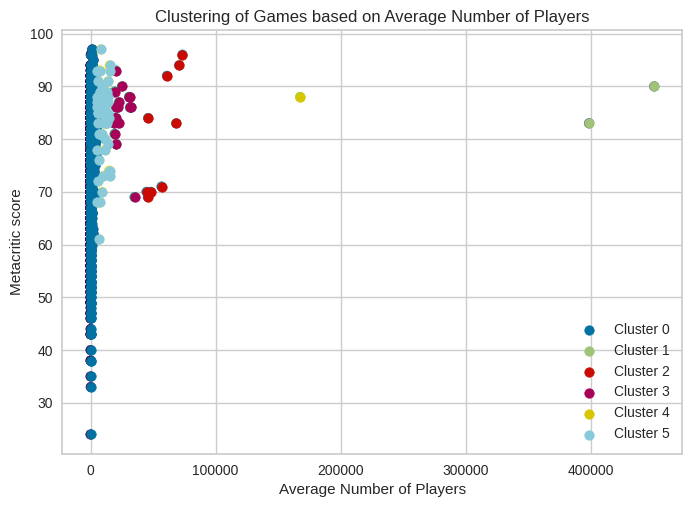

In [252]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Selecting the feature for clustering
X_pc = pc_enc[['Avg_players']]

# Amount of clusters
n_clusters = 6

# Fit the KMeans model
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
pc_enc['cluster'] = kmeans.fit_predict(X_pc)

# Visualize the clusters
plt.scatter(X_pc, pc_enc['Metacritic_score'], c=pc_enc['cluster'], cmap='viridis')
plt.xlabel('Average Number of Players')
plt.ylabel('Metacritic score')
plt.title('Clustering of Games based on Average Number of Players')

# Add cluster labels
for i in range(n_clusters):
    cluster_data = pc_enc[pc_enc['cluster'] == i]
    plt.scatter(cluster_data['Avg_players'], cluster_data['Metacritic_score'], label=f'Cluster {i}')

plt.legend()
plt.show()


In [253]:
# Group clusters based on average players

high_pc = pc_enc[(pc_enc.cluster == 1) | (pc_enc.cluster == 4)]
mid_pc = pc_enc[(pc_enc.cluster == 2) | (pc_enc.cluster == 3) | (pc_enc.cluster == 5)]
low_pc = pc_enc[(pc_enc.cluster == 0)]

In [254]:
# Define numeric features and drop low variance features
pc_numerics = ['Price', 'Avg_players', 'Release_date', 'Required_age', 'DLC_count', 'Metacritic_score', 'Achievements', 'Lang_count', 'Dev_released', 'Publisher_released']
pc_todrop = ['cluster', 'Windows', 'AppID', 'Name', 'Gore', 'Nudity', 'Sexual_Content', 'Early_Access', 'Violent']

In [ ]:
# Export descriptive statistics of numerical features per cluser group to latex table
desc_highpc = high_pc[pc_numerics].describe().round(2)
desc_midpc = mid_pc[pc_numerics].describe().round(2)
desc_lowpc = low_pc[pc_numerics].describe().round(2)

desc_highpc.to_latex('desc_highpc')
desc_midpc.to_latex('desc_midpc')
desc_lowpc.to_latex('desc_lowpc')

In [225]:
low_pc

,Mac,Linux,Action,Adventure,Casual,Free_to_Play,Indie,RPG,Racing,Simulation,Sports,Strategy,Captions_available,Commentary_available,In-App_Purchases,Includes_Source_SDK,Includes_level_editor,MMO,Single-player,Stats,VR_Support,Valve_Anti-Cheat_enabled,Lang_eng,Genre_PvP,Genre_Coop,Controller_support,Shared_screen,Steam_support,Genre_multiplayer
1,True,True,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,True,0,0,0,0,0,1
2,True,True,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,True,1,0,0,0,1,1
3,True,True,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,True,0,0,0,0,0,1
4,True,True,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,True,0,0,0,0,0,1
5,True,True,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,True,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008,False,False,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,True,0,0,1,0,1,0
2009,False,False,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,True,0,0,1,0,1,0
2010,False,False,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,True,1,0,0,0,0,1
2011,False,False,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,True,0,0,0,0,0,0


In [ ]:
# Drop the numerical features so histograms can be made from categorical features

high_pc = high_pc.drop(columns=pc_numerics)
high_pc = high_pc.drop(columns=pc_todrop)

mid_pc = mid_pc.drop(columns=pc_numerics)
mid_pc = mid_pc.drop(columns=pc_todrop)

low_pc = low_pc.drop(columns=pc_numerics)
low_pc = low_pc.drop(columns=pc_todrop)

In [226]:
# Get feature names for each cluster group

ft_hiPlayers = high_pc.columns  # Get the feature names
counts_hiPlayers = high_pc.sum()  # Sum the occurrences of each feature

ft_midPlayers = mid_pc.columns  
counts_midPlayers = mid_pc.sum()  

ft_lowPlayers = low_pc.columns  
counts_lowPlayers = low_pc.sum()  

In [234]:
pc_enc[(pc_enc.cluster == 2) | (pc_enc.cluster == 3) | (pc_enc.cluster == 5)].Avg_players.describe()

count       79.000000
mean     18223.764996
std      16173.167695
min       5102.956989
25%       7637.313610
50%      12730.250000
75%      20423.174974
max      73422.834951
Name: Avg_players, dtype: float64

In [235]:
pc_enc[(pc_enc.cluster == 0)].Avg_players.describe()

count    1931.000000
mean      284.519972
std       643.212356
min         0.040000
25%        14.775206
50%        49.656250
75%       189.519791
max      4896.115385
Name: Avg_players, dtype: float64

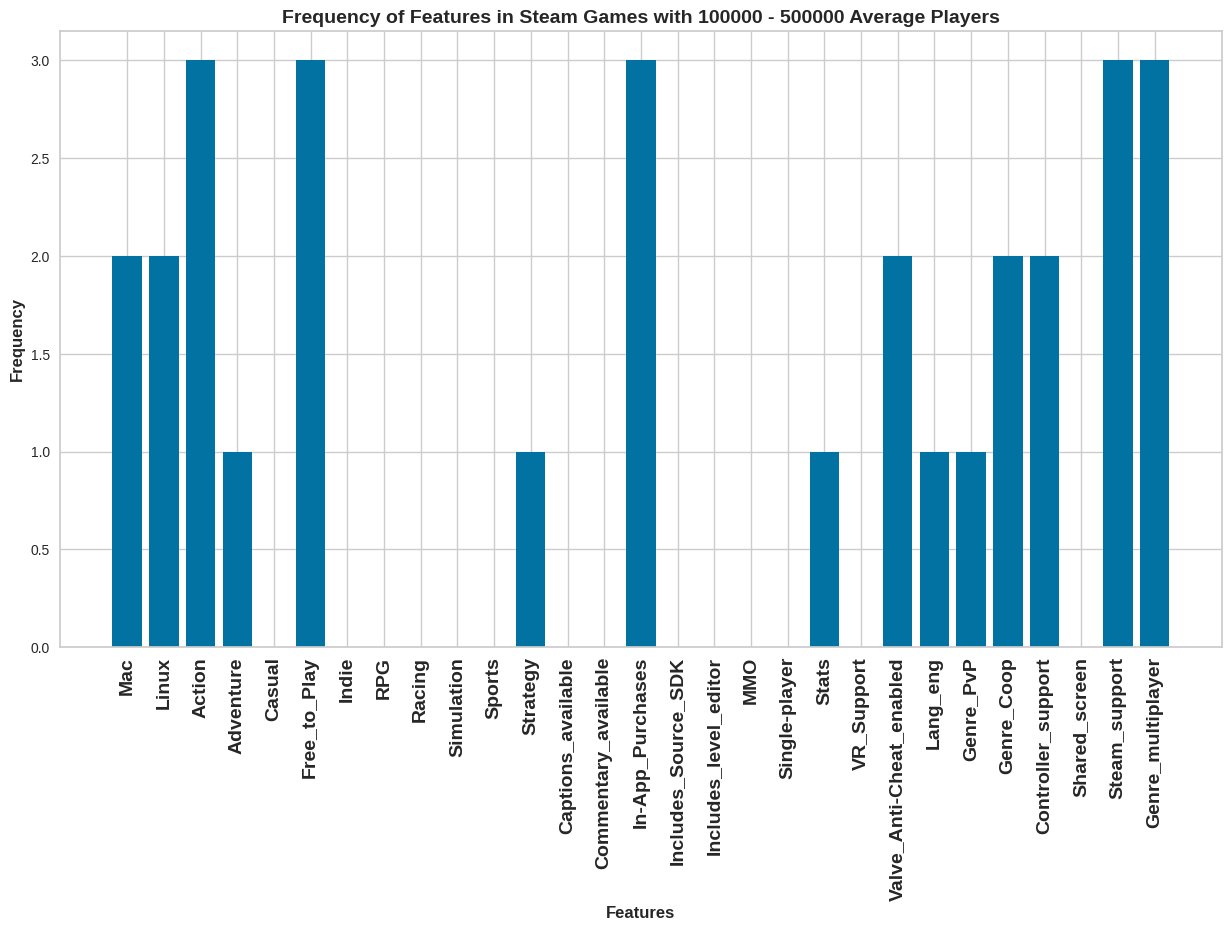

In [237]:
# Plot histograms for each cluster group
plt.figure(figsize=(15, 8))
plt.bar(ft_hiPlayers, counts_hiPlayers)
plt.xlabel('Features', fontsize=12, fontweight='bold')
plt.ylabel('Frequency', fontsize=12, fontweight='bold')
plt.title('Frequency of Features in Steam Games with 100000 - 500000 Average Players', fontsize=14, fontweight='bold')
plt.xticks(rotation=90, fontsize=14, fontweight='bold')
plt.show()


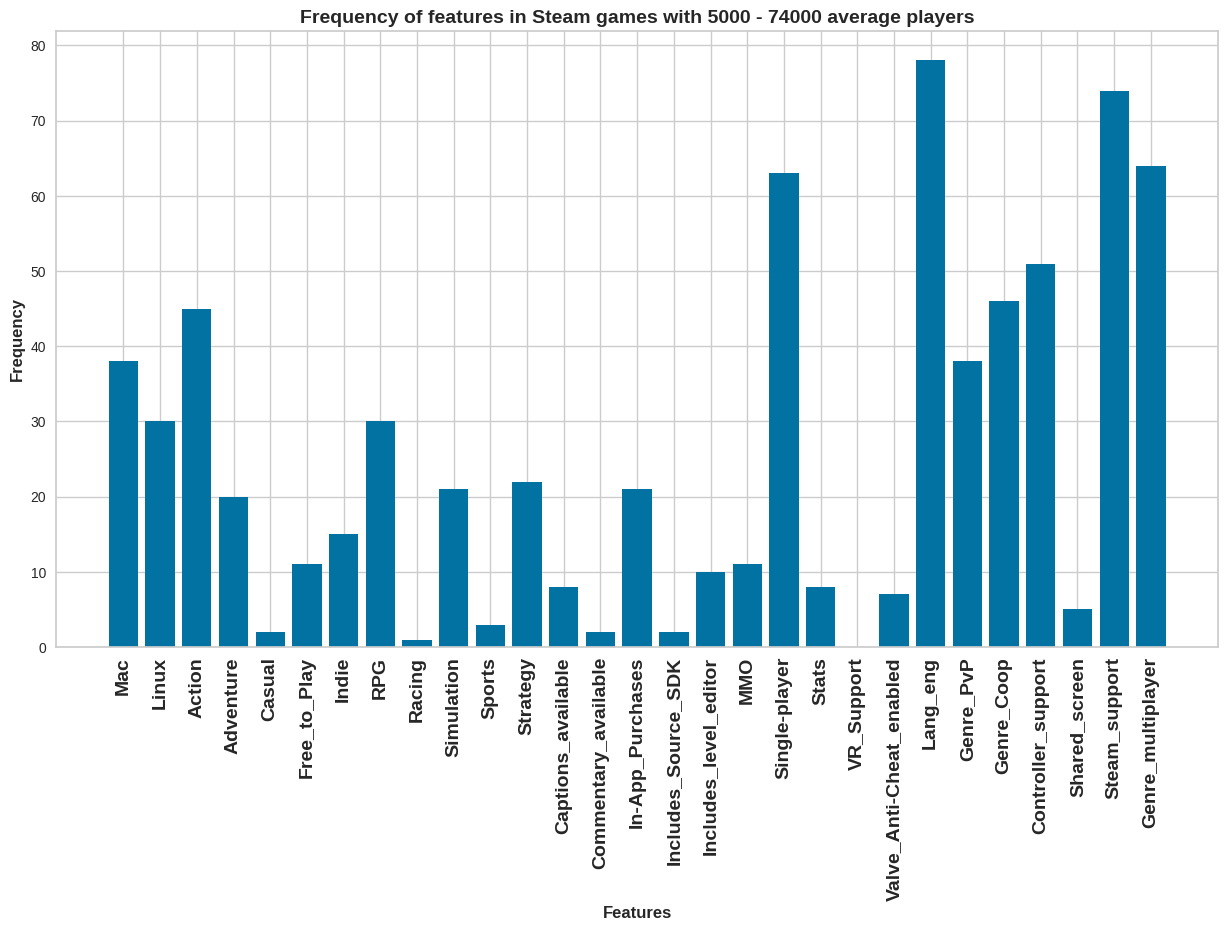

In [236]:
plt.figure(figsize=(15, 8))
plt.bar(ft_midPlayers, counts_midPlayers)
plt.xlabel('Features', fontsize=12, fontweight='bold')
plt.ylabel('Frequency', fontsize=12, fontweight='bold')
plt.title('Frequency of features in Steam games with 5000 - 74000 average players', fontsize=14, fontweight='bold')
plt.xticks(rotation=90, fontsize=14, fontweight='bold')
plt.show()

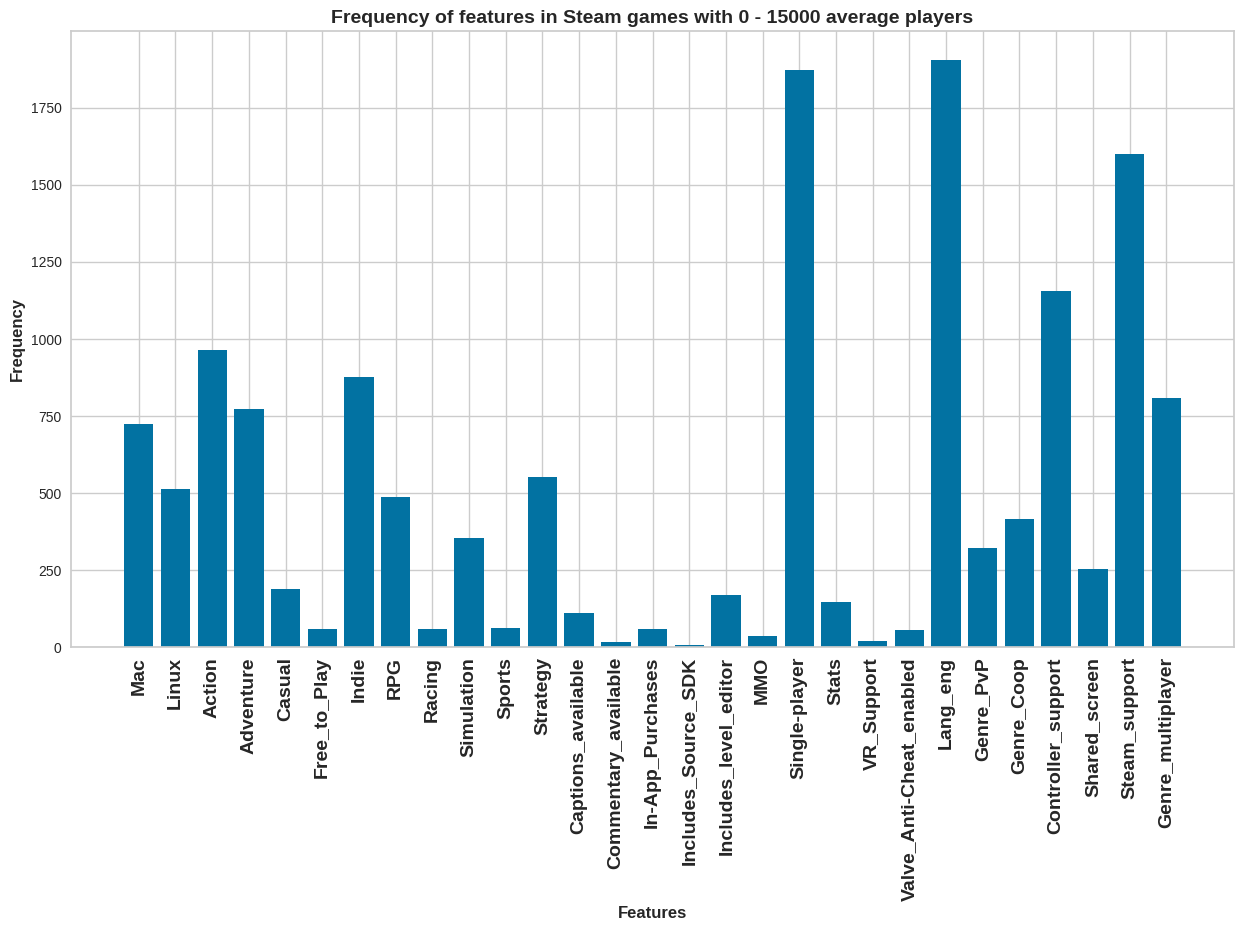

In [229]:
plt.figure(figsize=(15, 8))
plt.bar(ft_lowPlayers, counts_lowPlayers)
plt.xlabel('Features', fontsize=12, fontweight='bold')
plt.ylabel('Frequency', fontsize=12, fontweight='bold')
plt.title('Frequency of features in Steam games with 0 - 5000 average players', fontsize=14, fontweight='bold')
plt.xticks(rotation=90, fontsize=14, fontweight='bold')
plt.show()